# **Análisis exploratorio de Datos**

## Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from collections import Counter
import pickle

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14,6)


nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /home/sara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/sara/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/sara/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/sara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sara/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Sobre el dataset

El dataset utilizado contiene más de 2,400 currículos en formato de texto, cada uno con un identificador único y disponible también en HTML. Los currículos están categorizados según distintas áreas laborales, como Recursos Humanos, Diseño, Tecnología de la Información, Educación, Legal, Salud, Finanzas, Ventas, Ingeniería, entre otras.

Este conjunto de datos permite analizar y clasificar automáticamente los currículos según el perfil profesional, sirviendo como base para el desarrollo de modelos de aprendizaje automático en clasificación de empleo.

In [3]:
df = pd.read_csv('datos/Resume.csv')

df.head(5)

ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR

Se seleccionaron únicamente las columnas `ID`, `Resume_str` y `Category`. Las columnas `Resume_str` y `Category` se renombraron a `text` y `job_category`, respectivamente, para mayor claridad. Se eliminaron las filas que no contenían texto en la columna `text` y finalmente se muestran los primeros cinco registros para verificar los cambios.

In [4]:
df = df[['ID', 'Resume_str', 'Category']].copy()
df.rename(columns={'Resume_str': 'text', 'Category': 'job_category'}, inplace=True)
df.dropna(subset=['text'], inplace=True)
df.head(5)

ID                                               text job_category
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...           HR
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...           HR
2  33176873           HR DIRECTOR       Summary      Over 2...           HR
3  27018550           HR SPECIALIST       Summary    Dedica...           HR
4  17812897           HR MANAGER         Skill Highlights  ...           HR

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            2484 non-null   int64 
 1   text          2484 non-null   object
 2   job_category  2484 non-null   object
dtypes: int64(1), object(2)
memory usage: 58.3+ KB


El dataset contiene 2,484 registros con tres columnas: `ID` (identificador único), `text` (contenido del currículo) y `job_category` (categoría laboral). Todas las columnas están completas, sin valores nulos, sin embargo vamos a hacer un análisis más profundo para verificar todos los casos de datos faltantes.


In [6]:
df['text'].apply(lambda x: len(x.split())).describe()

count    2484.000000
mean      811.325282
std       371.007491
min         0.000000
25%       651.000000
50%       757.000000
75%       933.000000
max      5190.000000
Name: text, dtype: float64

## Valores faltantes

In [7]:
def detectar_datos_faltantes(df):
    resumen = []

    for col in df.columns:
        total = len(df)
        vacíos = (df[col] == '').sum() if df[col].dtype == 'object' else 0
        blancos = df[col].apply(lambda x: isinstance(x, str) and x.strip() == '').sum()
        texto_nan = df[col].astype(str).str.lower().isin(['nan', 'null']).sum()

        total_faltantes = vacíos + blancos + texto_nan

        if total_faltantes > 0:
            resumen.append({
                'columna': col,
                'vacíos': vacíos,
                'blancos': blancos,
                'texto_nan/null': texto_nan,
                'total_faltantes': total_faltantes,
                'porcentaje': round(100 * total_faltantes / total, 2)
            })

    return pd.DataFrame(resumen).sort_values(by='total_faltantes', ascending=False)


In [8]:
faltantes = detectar_datos_faltantes(df)
print(faltantes)


  columna  vacíos  blancos  texto_nan/null  total_faltantes  porcentaje
0    text       0        1               0                1        0.04


Se encontró un único registro con contenido en blanco. Dado que es solo un caso, procederemos a eliminarlo para mantener la consistencia del dataset.

In [9]:
df = df[~df['text'].apply(lambda x: isinstance(x, str) and x.strip() == '')]


## Análisis de Distribución de Clases

In [10]:
conteo_por_categoria = df['job_category'].value_counts()
print(conteo_por_categoria)


job_category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      119
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64


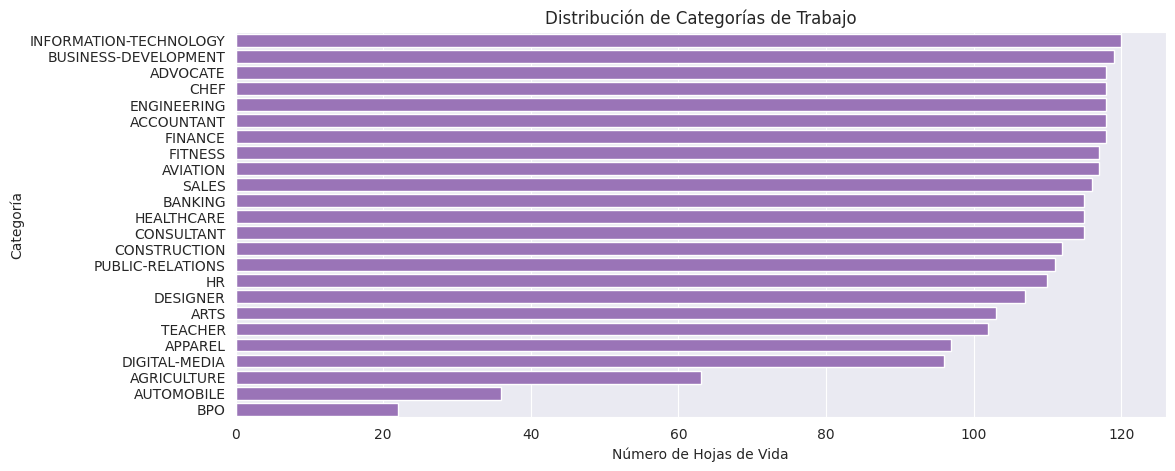

In [11]:
plt.figure(figsize=(12,5))
sns.countplot(y='job_category', data=df, order=df['job_category'].value_counts().index, color='#9c69c2')
plt.title('Distribución de Categorías de Trabajo')
plt.xlabel('Número de Hojas de Vida')
plt.ylabel('Categoría')
plt.show()


La distribución de las categorías laborales (`job_category`) en el dataset es desbalanceada.  

- Algunas categorías cuentan con un número alto de registros: `INFORMATION-TECHNOLOGY` (120), `BUSINESS-DEVELOPMENT` (119), `ADVOCATE` (118).  
- La mayoría de las categorías tienen cantidades medias de registros (100-120).  
- Algunas clases están poco representadas, como `AUTOMOBILE` (36) y `BPO` (22).  


## Conteo y longitudes de texto

### Longitud de Caracteres

In [12]:
df['char_count'] = df['text'].str.len()

### Conteo de Palabras

In [13]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

### Longitud Media de Palabra

In [14]:
df['mean_word_length'] = df['text'].map(lambda rev: np.mean([len(word) for word in rev.split()]))


### Longitud media de oraciones

In [15]:
df['mean_sent_length'] = df['text'].map(lambda rev: np.mean([len(sent) for sent in sent_tokenize(rev)]))

In [16]:
df.head(10)

ID                                               text job_category  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...           HR   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...           HR   
2  33176873           HR DIRECTOR       Summary      Over 2...           HR   
3  27018550           HR SPECIALIST       Summary    Dedica...           HR   
4  17812897           HR MANAGER         Skill Highlights  ...           HR   
5  11592605           HR GENERALIST       Summary     Dedic...           HR   
6  25824789           HR MANAGER       Summary    HUMAN RES...           HR   
7  15375009           HR MANAGER         Professional Summa...           HR   
8  11847784           HR SPECIALIST       Summary    Posses...           HR   
9  32896934           HR CLERK       Summary    Translates ...           HR   

   char_count  word_count  mean_word_length  mean_sent_length  
0        5442         674          6.459941        205.538462  
1        5572         708          6.307910        202.074074  
2        7720        1017          6.218289        199.921053  
3        2855         379          5.997361        164.823529  
4        9172        1206          6.368159        164.236364  
5        5480         666          6.735736        153.942857  
6        5250         637          6.872841        171.966667  
7        9033        1106          6.813743        106.277108  
8        6720         796          6.988693        119.000000  
9        5978         716          6.825419        195.666667

#### Observaciones sobre las características de los textos

1. **Longitud de los currículos**  
   La columna `char_count` indica la cantidad de caracteres por currículo, que en este conjunto de ejemplo va aproximadamente de 2,855 a 9,172 caracteres. Esto muestra que hay **variabilidad significativa** en el tamaño de los textos, desde resúmenes cortos hasta currículos muy detallados.

2. **Cantidad de palabras (`word_count`)**  
   El número de palabras oscila entre 379 y 1,206 palabras, lo que coincide con la variabilidad en la longitud de los textos. Los textos más largos no necesariamente tienen palabras más largas, pero sí más información que podría ser relevante para la clasificación.

3. **Longitud media de palabras (`mean_word_length`)**  
   La longitud promedio de palabra se mantiene bastante estable alrededor de 6 a 7 caracteres. Esto indica un **uso de vocabulario consistente**, sin textos con palabras extremadamente largas o cortas que podrían sesgar embeddings o representaciones.

4. **Longitud media de oraciones (`mean_sent_length`)**  
   Varía entre aproximadamente 106 y 205 palabras por oración. Algunas filas muestran oraciones extremadamente largas, lo que podría reflejar resúmenes muy densos o falta de puntuación clara en algunos currículos. 

#### Conclusión general

El dataset presenta **gran heterogeneidad en la longitud de los currículos**, lo que sugiere que:  
- Se podría necesitar **normalización o truncamiento** de texto para entrenar modelos de NLP.  
- Los modelos basados en **transformers** pueden manejar bien textos largos, pero para **LSTM o CNN** conviene limitar el tamaño de entrada.  
- La consistencia en `mean_word_length` es positiva, ya que facilita la creación de embeddings estables.


In [17]:
def visualize(col):
    # --- BOX PLOT ---
    plt.figure(figsize=(12,6))

    # Paleta personalizada tipo morado pastel
    palette = sns.blend_palette(["#9c69c2", "#D5C7EF"], n_colors=df['job_category'].nunique())

    sns.boxplot(
        data=df,
        x='job_category',
        y=col,
        hue='job_category',
        palette=palette,
        dodge=False,
        legend=False
    )

    plt.xticks(rotation=90)
    plt.title(f'Distribución de {col} por Categoría (Boxplot)', fontsize=16)
    plt.xlabel('Categoría')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

    
    # --- HISTOGRAMA ---
    plt.figure(figsize=(10,6))
    sns.histplot(df[col], bins=30, kde=True, color='#9c69c2')  
    plt.title(f'Distribución general de {col} (Histograma)')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

    # --- DENSIDAD (KDE) ---
    plt.figure(figsize=(10,6))
    sns.kdeplot(data=df, x=col, hue='job_category', common_norm=False, palette='Pastel2', alpha=0.7)
    plt.title(f'Distribución de densidad de {col} por Categoría (KDE)')
    plt.xlabel(col)
    plt.ylabel('Densidad')
    plt.tight_layout()
    plt.show()


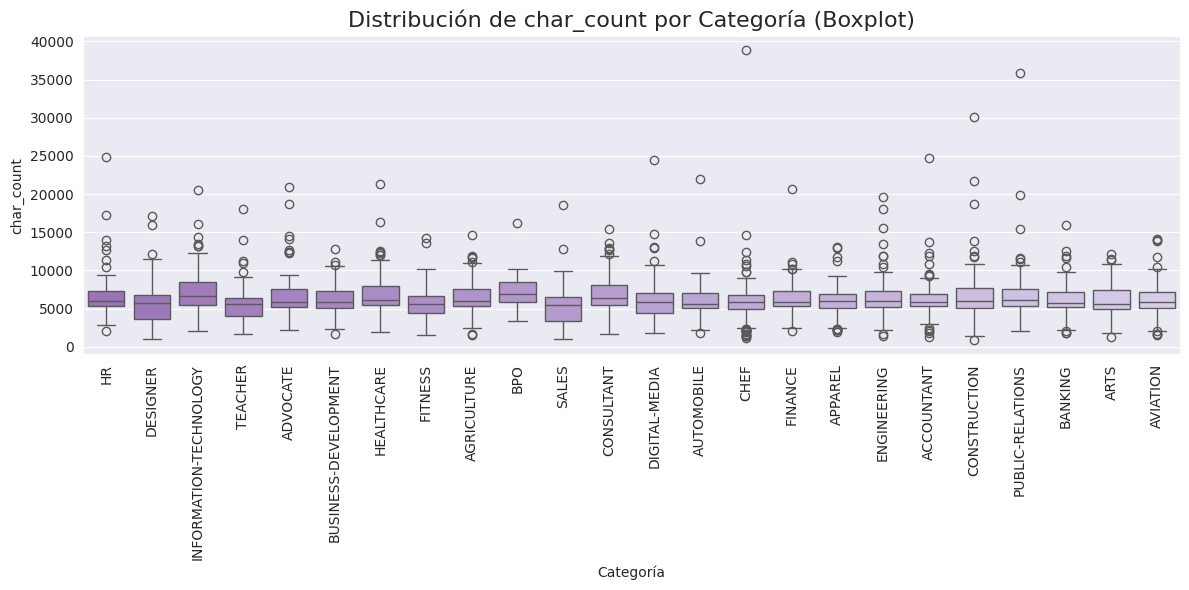

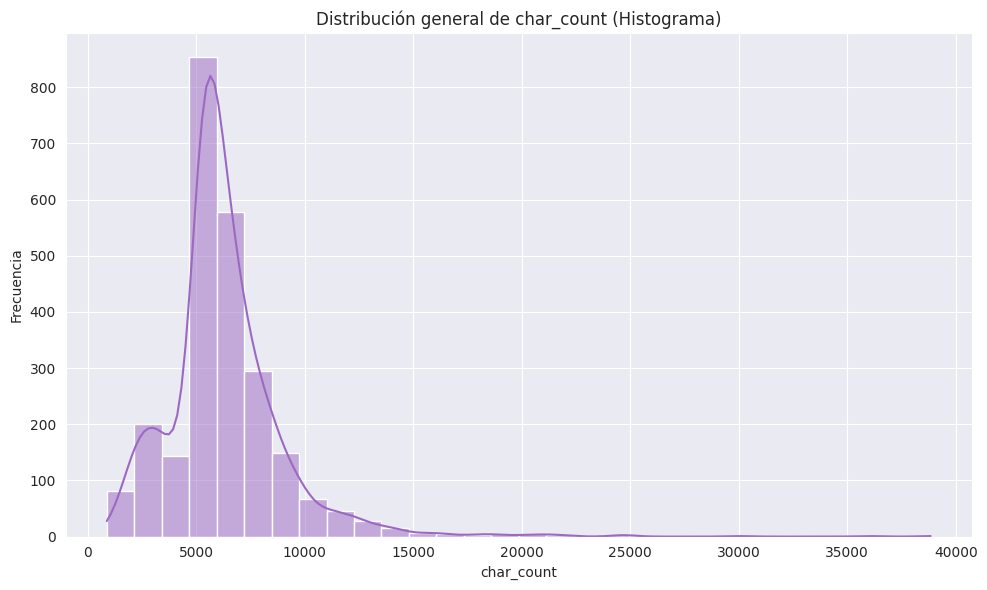

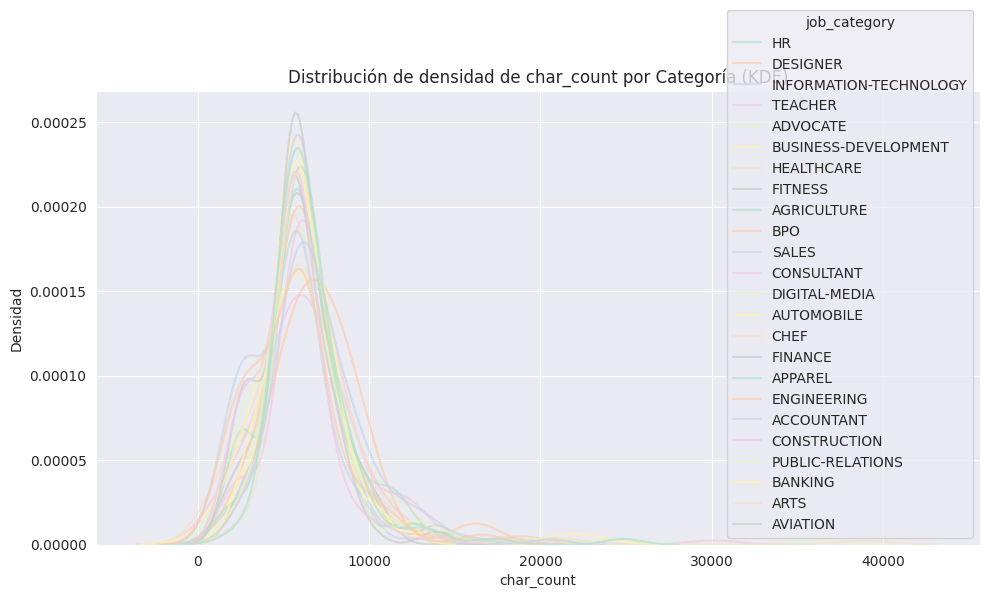

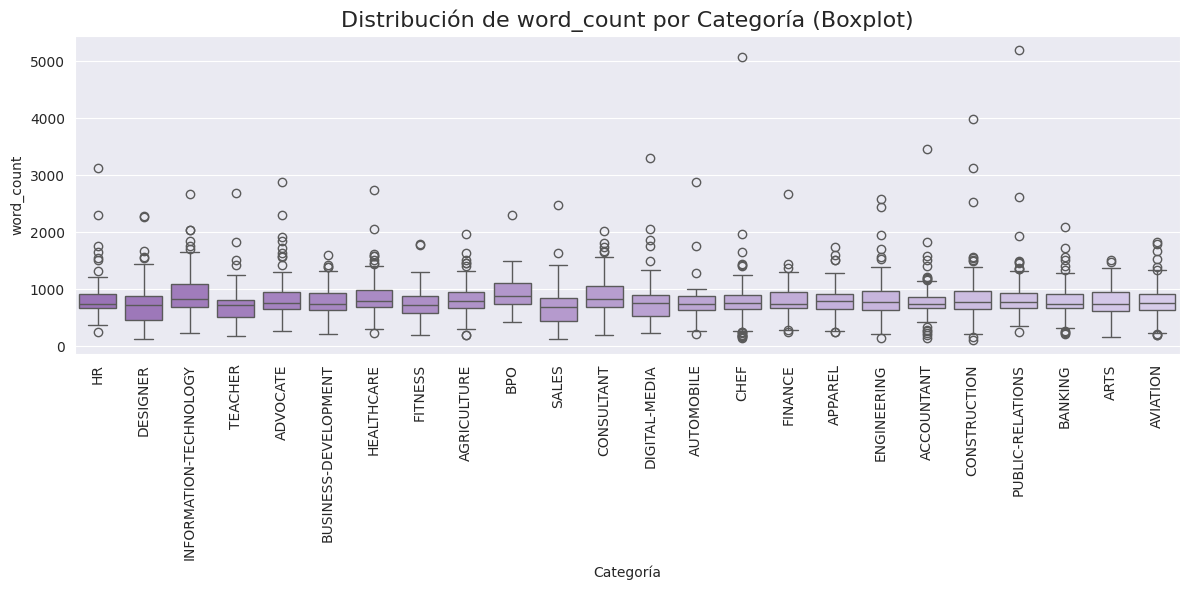

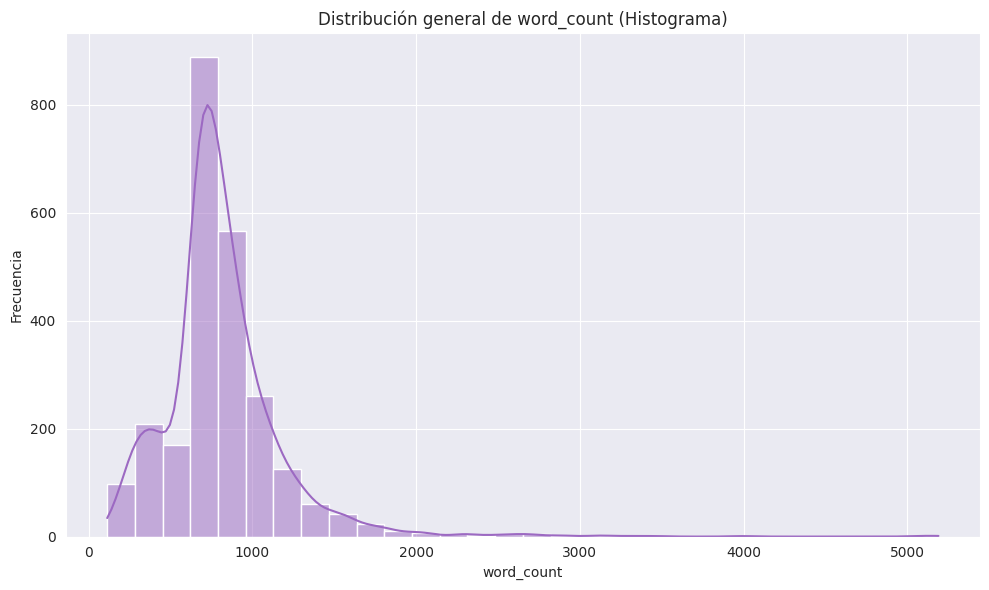

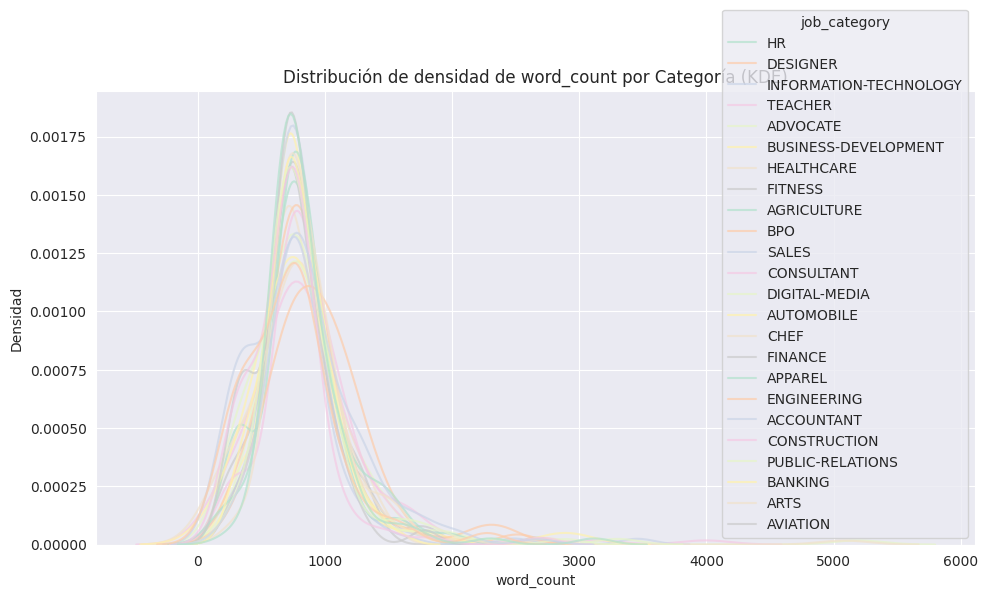

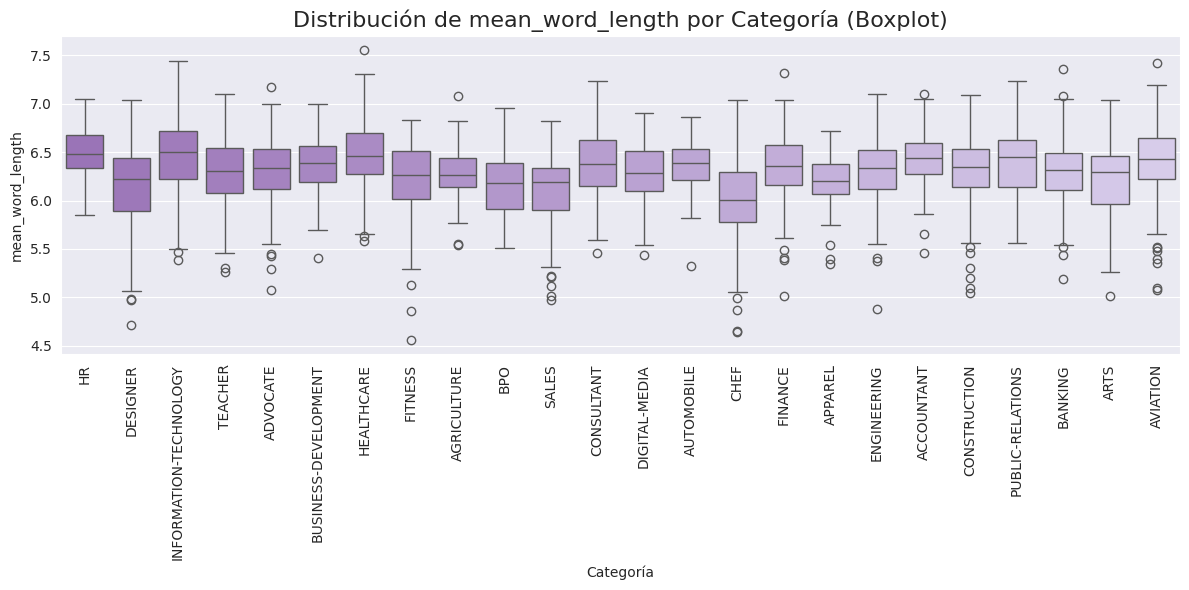

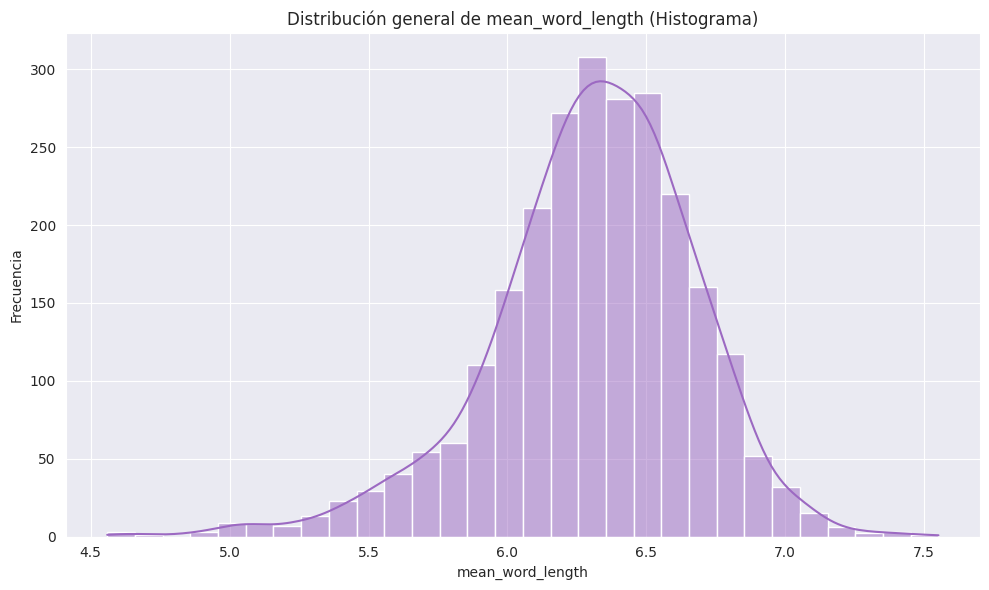

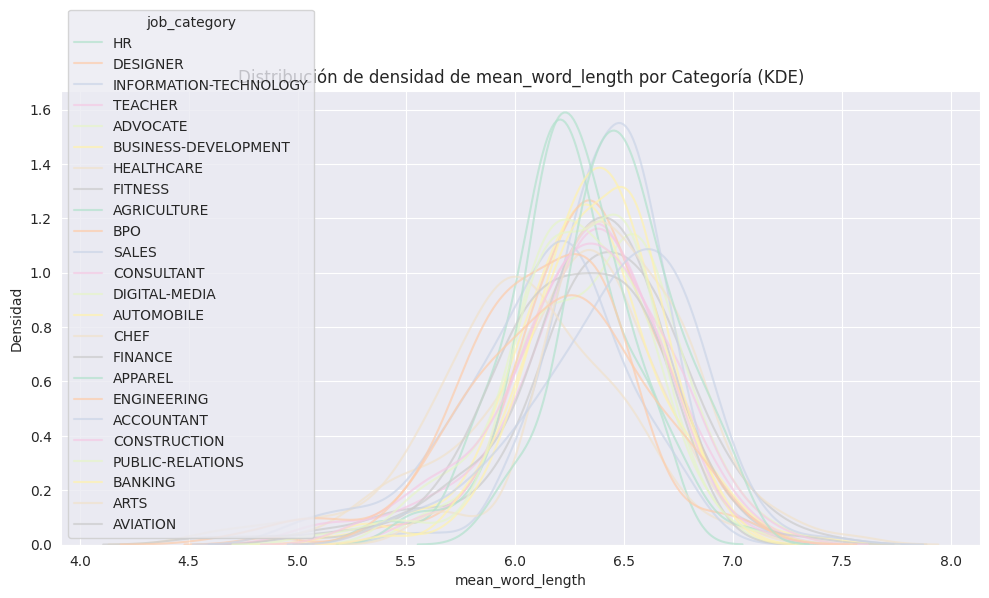

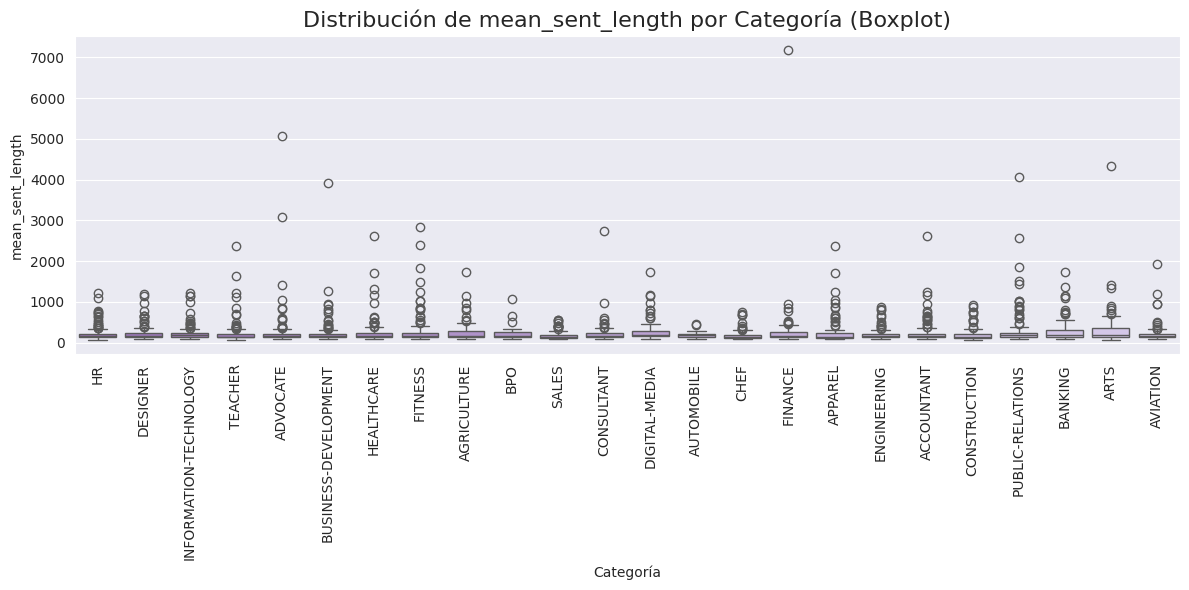

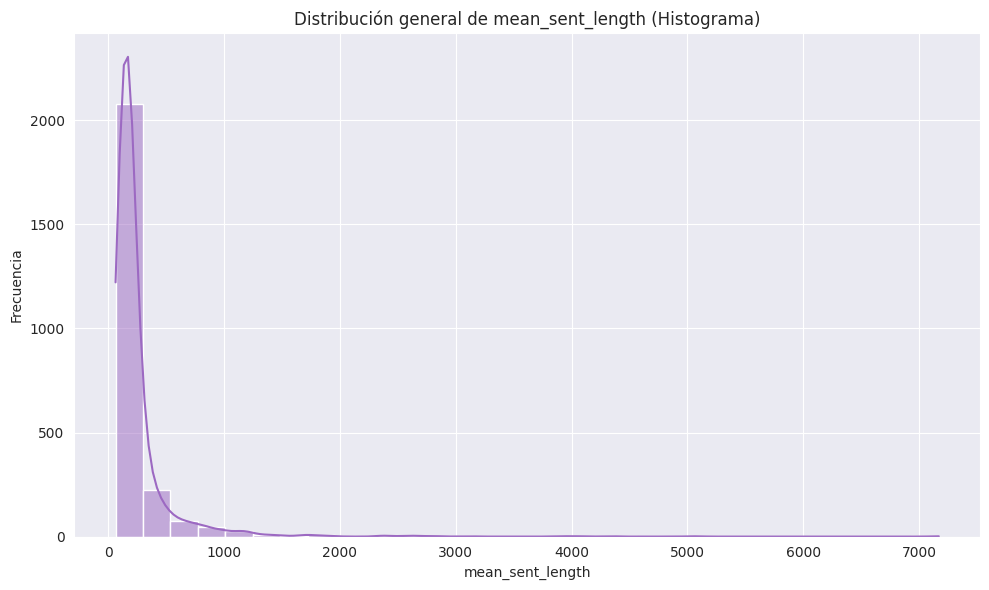

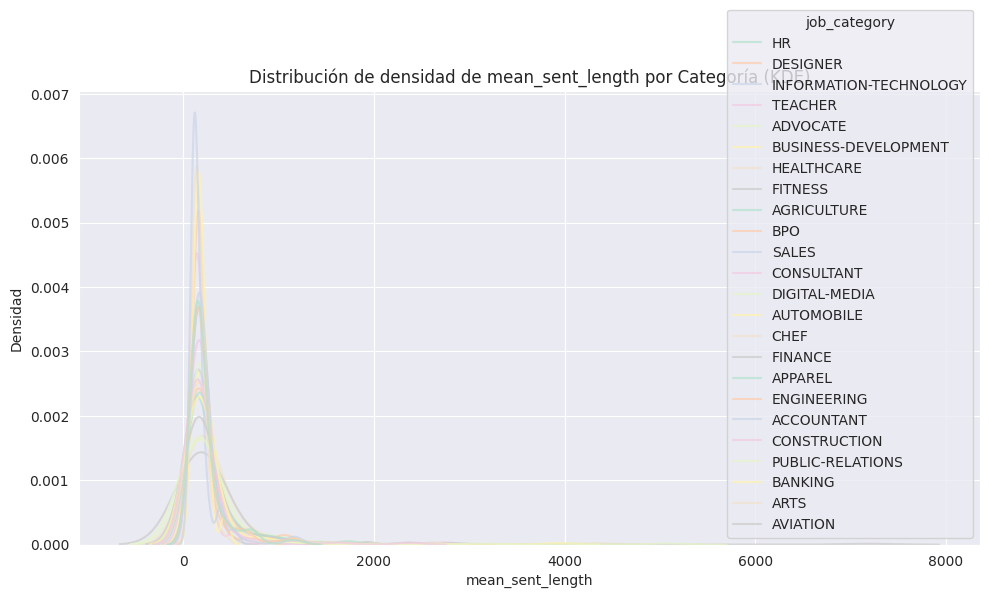

In [18]:
for col in ['char_count', 'word_count', 'mean_word_length', 'mean_sent_length']:
    visualize(col)



| Métrica                        | Comportamiento Individual                                                                                                                                       | Valor Predictivo                                                                                   |
|-------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|
|  **Conteo de Caracteres** (`char_count`) | - Distribución sesgada positivamente, moda entre 5.000 y 7.000 caracteres. <br> - Outliers extremos (hasta 35.000+). <br> - Distribución homogénea por categoría. | - **Bajo**: no discrimina entre categorías. <br> - Útil para truncamiento, no como feature principal. |
|  **Conteo de Palabras** (`word_count`)   | - Distribución similar a `char_count`, moda cercana a 800 palabras. <br> - Outliers frecuentes (hasta 5.000+ palabras). <br> - Alta superposición entre categorías. | - **Limitado**: no diferencia roles. <br> - Útil para normalizar entradas en modelos con límite de tokens. |
|  **Longitud Media de Palabra** (`mean_word_length`) | - Distribución normal centrada en ~6.3 caracteres. <br> - Variabilidad baja entre categorías. <br> - Outliers simétricos y poco extremos.                     | - **Muy bajo**: no discrimina entre categorías. <br> - Puede reflejar tecnicismo, pero no de forma robusta. |
|  **Longitud Media de Oración** (`mean_sent_length`) | - Distribución altamente sesgada, moda cercana a cero. <br> - Afectada por errores de tokenización. <br> - Outliers reflejan ruido de formato.               | - **Nulo**: no refleja diferencias reales. <br> - Útil como indicador de calidad de extracción.         |


Al evaluar las cuatro métricas de longitud textual: **conteo de caracteres**, **conteo de palabras**, **longitud media de palabra** y **longitud media de oración**. A través de histogramas, boxplots y curvas de densidad (KDE), se ha determinado que estas métricas, aunque útiles para diagnóstico y preprocesamiento, **no poseen valor predictivo significativo** para la clasificación en las 22 categorías laborales del dataset.


 1.  Homogeneidad en Longitud y Conteo

Las métricas de `char_count` y `word_count` presentan distribuciones fuertemente asimétricas positivas, con la mayoría de los currículums concentrados entre **5.000–7.000 caracteres** y **600–1.000 palabras**. Los boxplots y KDEs por categoría muestran una **superposición casi total** de medianas e IQRs, lo que indica que la longitud textual es **uniforme entre categorías** como HR, ENGINEERING o AVIATION.

**Implicación:** Estas métricas no permiten distinguir entre clases. Aunque útiles para normalizar entradas, no deben considerarse como variables predictivas principales.


 2.  Estabilidad vs. Ruido Estructural

La **longitud media de palabra** (`mean_word_length`) es la métrica más estable, con una distribución normal centrada en ~6.3 caracteres. Aunque se observan ligeras diferencias (e.g., ADVOCATE más alto que DESIGNER), la superposición entre categorías es demasiado grande para ser útil en clasificación.

En contraste, la **longitud media de oración** (`mean_sent_length`) es la más ruidosa y sesgada. La mayoría de los textos presentan valores bajos, y los outliers extremos reflejan errores de tokenización causados por el formato de viñetas típico en currículums. Esta métrica **no refleja estructura lingüística real**, sino artefactos de extracción.

**Implicación:** `mean_word_length` puede tener valor como feature auxiliar en modelos multivariados, pero `mean_sent_length` debe tratarse como indicador de calidad de extracción, no como variable de modelado.

 3.  Valor Predictivo Conjunto

Ninguna de las métricas de longitud analizadas permite discriminar eficazmente entre las 22 categorías laborales. Las distribuciones son homogéneas, los outliers son frecuentes pero no informativos, y las diferencias entre sectores son mínimas o inexistentes.



***Conclusión:*** El éxito del modelo dependerá exclusivamente del **contenido semántico** de los currículums, no de su estructura superficial. Las métricas de longitud textual han cumplido su rol como herramientas de diagnóstico y limpieza, pero no aportan valor predictivo directo. El proyecto debe avanzar hacia una **ingeniería de features semántica**, donde el contenido —no la forma— sea el motor de la clasificación. Este enfoque garantizará modelos más precisos, interpretables y adaptables a nuevos contextos.


## Análisis de Frecuencia de Términos

### Preprocesamiento de texto básico inicial

El próximo paso es realizar un preprocesamiento del texto, donde se normalizará el contenido convirtiéndolo a minúsculas, eliminando puntuación irrelevante y conservando símbolos técnicos, útiles para identificar habilidades. Luego se eliminarán las stopwords en inglés para reducir ruido, y opcionalmente se aplicará stemming para agrupar variantes morfológicas. El resultado será un texto limpio, segmentado y listo para análisis de frecuencia.

In [19]:
def extract_symbol_bigrams(df_subset, symbol):
    bigrams = []
    for text in df_subset['text']:
        tokens = text.split()
        pairs = zip(tokens, tokens[1:])
        bigrams.extend([bg for bg in pairs if symbol in bg])
    return Counter(bigrams).most_common(15)

df_amp = df[df['text'].str.contains(r'&', regex=False)]
df_slash = df[df['text'].str.contains(r'/', regex=False)]

bigrams_amp = extract_symbol_bigrams(df_amp, '&')
bigrams_slash = extract_symbol_bigrams(df_slash, '/')

print("Bigramas con '&':", bigrams_amp)
print("Bigramas con '/':", bigrams_slash)


Bigramas con '&': [(('Training', '&'), 59), (('Sales', '&'), 56), (('&', 'Development'), 55), (('Marketing', '&'), 49), (('&', 'Marketing'), 44), (('Management', '&'), 40), (('Finance', '&'), 37), (('Planning', '&'), 34), (('P', '&'), 32), (('Design', '&'), 30), (('&', 'Management'), 28), (('&', 'Technology'), 25), (('I', '&'), 25), (('Development', '&'), 25), (('Accounting', '&'), 25)]
Bigramas con '/': [(('Name', '/'), 57), (('Manager', '/'), 44), (('/', 'May'), 19), (('service', '/'), 18), (('Management', '/'), 17), (('/', 'Project'), 15), (('Sales', '/'), 14), (('Tournament', '/'), 14), (('/', 'Business'), 13), (('Engineer', '/'), 10), (('/', 'Company'), 10), (('MANAGER', '/'), 10), (('Coordinator', '/'), 10), (('/', '4.0'), 10), (('/', 'Office'), 9)]


Se ha decidido conservar el símbolo `&` durante el preprocesamiento porque aparece con frecuencia en combinaciones semánticamente relevantes dentro de los currículums, como `sales & marketing`, `research & development`, o `food & beverage`. Estas expresiones representan áreas funcionales, departamentos o habilidades compuestas que aportan valor informativo al análisis. Eliminar este símbolo podría fragmentar términos clave y reducir la calidad semántica del corpus, por lo que se mantiene como parte del vocabulario procesado.

De igual forma, se conserva el símbolo `/`, ya que aparece en estructuras organizativas y expresiones técnicas como `Name / Manager`, `Sales / Marketing`, `Coordinator / Project`, o `Business / Development`. Estas combinaciones reflejan roles duales, áreas compartidas y funciones compuestas que son comunes en perfiles profesionales. Eliminar `/` podría distorsionar la relación entre conceptos clave, por lo que también se mantiene como parte del texto procesado.


In [20]:
def preprocess(text, stopwords_set=None):
    if not isinstance(text, str) or not text.strip():
        return ""

    text = text.lower()
    text = re.sub(r'[^\w\s/&]', ' ', text)
    tokens = text.split()

    if stopwords_set:
        tokens = [word for word in tokens if word not in stopwords_set]

    return ' '.join(tokens)

# Aplicación inicial
df['text'] = df['text'].apply(lambda x: preprocess(x, stopwords.words('english')))


In [21]:
df['text'] = df['text'].map(lambda x: preprocess(x))

Este es un ejemplo de cómo quedaron las hojas de vida luego del preprocesamiento inicial:

In [22]:
df['text'][0]

'hr administrator/marketing associate hr administrator summary dedicated customer service manager 15 years experience hospitality customer service management respected builder leader customer focused teams strives instill shared enthusiastic commitment customer service highlights focused customer satisfaction team management marketing savvy conflict resolution techniques training development skilled multi tasker client relations specialist accomplishments missouri dot supervisor training certification certified ihg customer loyalty marketing segment hilton worldwide general manager training certification accomplished trainer cross server hospitality systems hilton onq micros opera pms fidelio opera reservation system ors holidex completed courses seminars customer service sales strategies inventory control loss prevention safety time management leadership performance assessment experience hr administrator/marketing associate hr administrator dec 2013 current company name city state hel

### Palabras más Frecuentes (Top N)

In [23]:
all_words = ' '.join(df['text']).split()
counter = Counter(all_words)
most_common = counter.most_common(20)
most_common

[('state', 16134),
 ('company', 15204),
 ('city', 15072),
 ('management', 12076),
 ('name', 11739),
 ('sales', 8184),
 ('customer', 7863),
 ('business', 7777),
 ('skills', 7718),
 ('new', 6379),
 ('service', 6169),
 ('team', 6049),
 ('development', 5666),
 ('experience', 5625),
 ('training', 5589),
 ('project', 5296),
 ('work', 4804),
 ('&', 4771),
 ('information', 4489),
 ('marketing', 4398)]

In [24]:
def plot_top_words(most_common):

    words, freqs = zip(*most_common)

    # Paleta personalizada
    palette = sns.blend_palette(["#9c69c2", "#D5C7EF"], n_colors=20)

    plt.figure(figsize=(12,6))
    sns.barplot(x=list(words), y=list(freqs), hue=list(words), palette=palette, legend=False)
    plt.title(f'Top {20} palabras más frecuentes en el corpus', fontsize=16)
    plt.xticks(rotation=45)
    plt.ylabel('Frecuencia')
    plt.xlabel('Palabra')
    plt.tight_layout()
    plt.show()



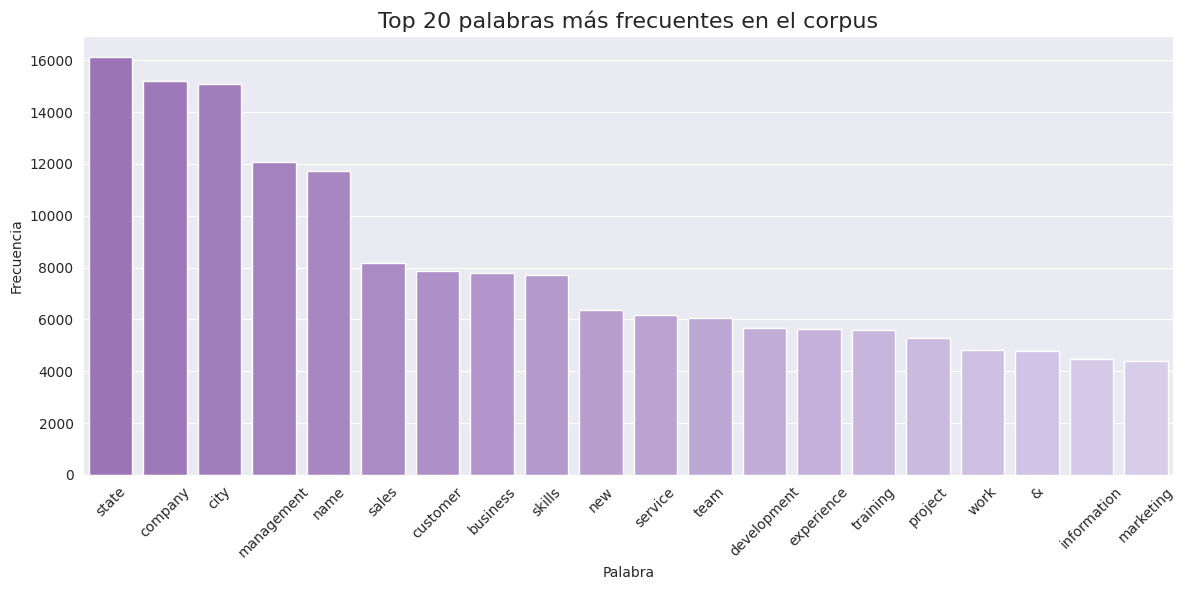

In [25]:
plot_top_words(most_common)


Tras aplicar el preprocesamiento al conjunto de currículums, se identificaron las palabras más frecuentes en el texto. Entre ellas destacan términos como `state`, `company`, `city`, `management`, `sales`, `customer`, `business`, `skills`, `service`, `team`, `development`, `experience`, `training`, `project`, `work`, `information` y `marketing`. Estas palabras reflejan áreas funcionales, roles laborales, competencias técnicas y organizativas comunes en los perfiles analizados. También se observa una alta frecuencia del símbolo `&`, lo que respalda su conservación en el preprocesamiento por su valor semántico en expresiones compuestas como `sales & marketing` o `research & development`.

### Word Clouds

In [26]:
def plot_wordcloud(df, col='text'):
    text = ' '.join(df[col])

    palette = sns.blend_palette(["#9c69c2", "#D5C7EF"], n_colors=10)
    palette_rgb = (np.array(palette) * 255).astype(int)
    palette_hex = ['#%02x%02x%02x' % tuple(rgb) for rgb in palette_rgb]

    def random_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return np.random.choice(palette_hex)

    wc = WordCloud(
        width=1000, height=500,
        background_color='white',
        color_func=random_color_func
    ).generate(text)

    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de palabras del corpus completo', fontsize=16)
    plt.tight_layout()
    plt.show()



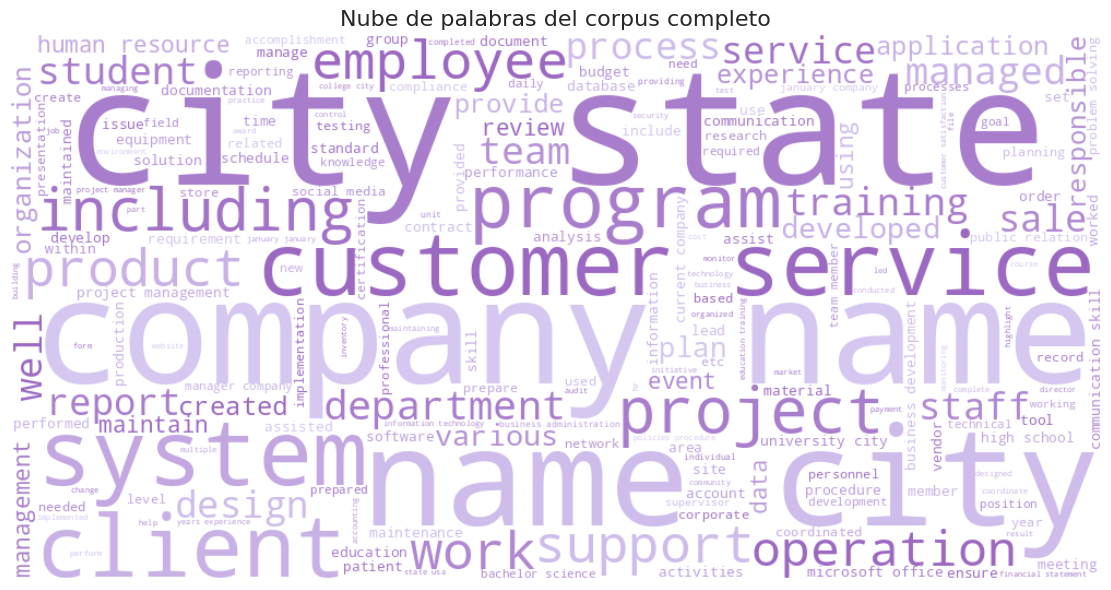

In [27]:
plot_wordcloud(df, col='text')

### Frecuencia por Clase

In [28]:
def print_top_words_by_category(df, col='text', cat_col='job_category', top_n=10, max_classes=10):
    top_categories = df[cat_col].value_counts().nlargest(max_classes).index

    for category in top_categories:
        subset = df[df[cat_col] == category]
        words = ' '.join(subset[col]).split()
        counter = Counter(words)
        common = counter.most_common(top_n)

        print(f"\n🔹 Categoría: {category}")
        for word, freq in common:
            print(f"  {word}: {freq}")

print_top_words_by_category(df, col='text', cat_col='job_category', top_n=10, max_classes=10)


🔹 Categoría: INFORMATION-TECHNOLOGY
  management: 893
  information: 857
  technology: 740
  systems: 736
  support: 669
  network: 659
  company: 650
  state: 638
  city: 616
  system: 580

🔹 Categoría: BUSINESS-DEVELOPMENT
  sales: 1434
  business: 1192
  company: 828
  state: 792
  development: 764
  city: 717
  management: 628
  marketing: 611
  new: 609
  name: 565

🔹 Categoría: ADVOCATE
  state: 922
  city: 832
  customer: 734
  company: 730
  name: 620
  service: 537
  skills: 512
  management: 472
  sales: 330
  team: 296

🔹 Categoría: CHEF
  food: 1343
  state: 805
  city: 761
  company: 700
  chef: 675
  name: 594
  kitchen: 582
  service: 476
  management: 460
  staff: 447

🔹 Categoría: ENGINEERING
  engineering: 963
  company: 653
  city: 643
  state: 631
  management: 520
  name: 510
  project: 510
  systems: 431
  team: 407
  design: 402

🔹 Categoría: ACCOUNTANT
  accounting: 1214
  financial: 1075
  accounts: 788
  state: 783
  company: 776
  city: 680
  management: 582

In [29]:
def plot_top_words_by_category(df, col='text', cat_col='job_category', top_n=10, max_classes=10):
    top_categories = df[cat_col].value_counts().nlargest(max_classes).index
    num_cols = 5
    num_rows = -(-len(top_categories) // num_cols)  # ceil division

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))
    axes = axes.flatten()

    for i, category in enumerate(top_categories):
        subset = df[df[cat_col] == category]
        words = ' '.join(subset[col]).split()
        counter = Counter(words)
        common = counter.most_common(top_n)
        words, freqs = zip(*common)

        sns.barplot(x=list(words), y=list(freqs), hue=list(words), palette = sns.blend_palette(["#9c69c2", "#D5C7EF"], n_colors=10), ax=axes[i], legend=False)
        axes[i].set_title(f'{category}', fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_ylabel('Frecuencia')
        axes[i].set_xlabel('')

    # Ocultar ejes vacíos si hay menos de 5*n
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Top {top_n} palabras por categoría laboral', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



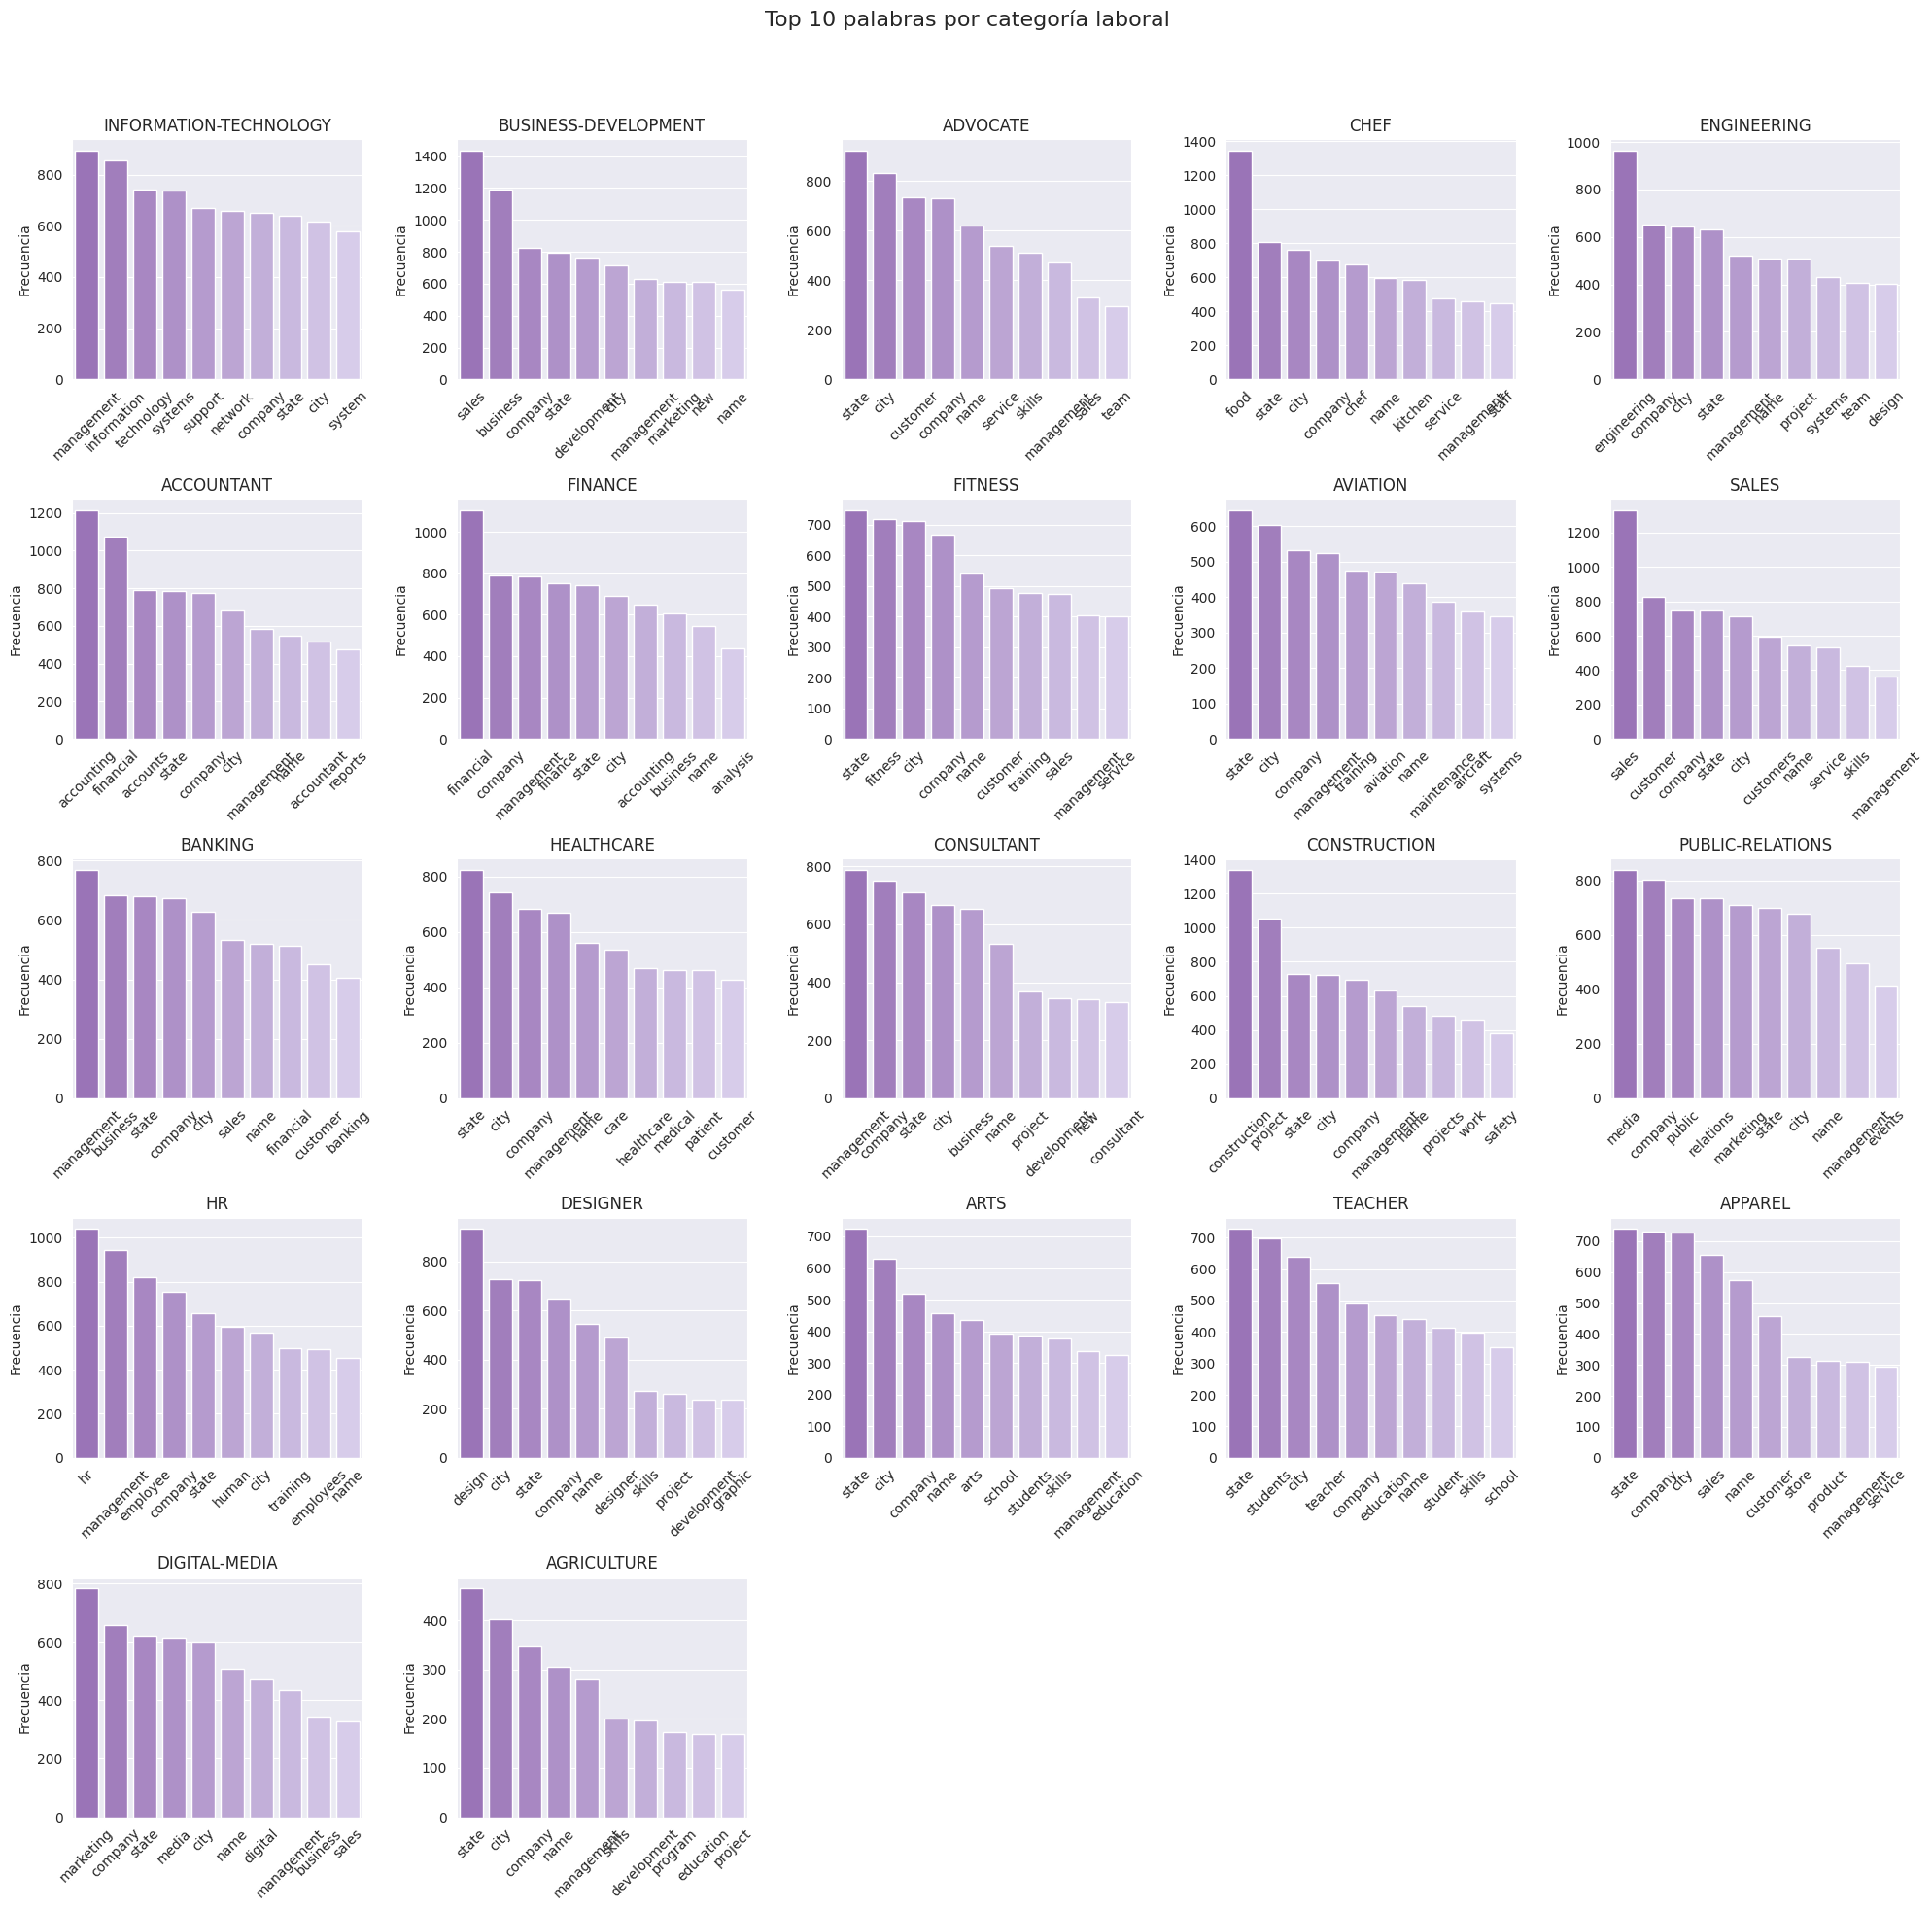

In [30]:
plot_top_words_by_category(df, col='text', cat_col='job_category', top_n=10, max_classes=22)


#### 1.  Ruido Estructural y Palabras de Lista Negra

Se observa un conjunto de palabras que aparecen con alta frecuencia en casi todas las categorías, lo que indica que podrían ser stopwords no eliminadas o términos estructurales comunes en los currículums. Estas palabras no aportan valor predictivo y deben considerarse para exclusión.

#####  Términos de Ruido/Estructurales Comunes

| Término        | Implicación Semántica |
|----------------|------------------------|
| `state`, `city`, `company`, `name` | Probablemente residuales de direcciones, nombres de empleadores o plantillas de CV. No distinguen categorías. |
| `management`, `team` | Aunque relevantes, su uso genérico en casi todas las categorías sugiere que no aportan discriminación técnica. |
| `customer`, `service` | Comunes en roles de servicio (Advocate, Fitness, Sales), pero también aparecen como ruido en otras categorías. |

**Conclusión:**  
La limpieza inicial de stopwords fue incompleta. Es imperativo eliminar `state`, `city`, `company`, `name` y evaluar la exclusión de `management`, `customer`, `service` para mejorar la señal semántica del corpus.

---

#### 2.  Palabras Predictivas y Distintivas por Categoría

Estas palabras son altamente representativas de cada clase laboral y aportan valor para tareas de clasificación supervisada.

| Categoría               | Palabras Predictivas                          | Observación Semántica |
|-------------------------|-----------------------------------------------|------------------------|
| INFORMATION-TECHNOLOGY  | `information`, `technology`, `systems`, `support`, `network`, `system` | Vocabulario clásico de TI, centrado en infraestructura y soporte. |
| BUSINESS-DEVELOPMENT    | `sales`, `business`, `development`, `marketing`, `new` | Énfasis en crecimiento comercial y ventas. |
| ADVOCATE                | `customer`, `service`, `skills`               | Foco en atención al cliente y habilidades blandas. |
| CHEF                    | `food`, `chef`, `kitchen`, `staff`            | Léxico de la industria alimentaria. |
| ENGINEERING             | `engineering`, `project`, `systems`, `design` | Enfoque en procesos técnicos y diseño. |
| ACCOUNTANT              | `accounting`, `financial`, `accounts`, `accountant`, `reports` | Vocabulario específico de contabilidad. |
| FINANCE                 | `financial`, `finance`, `accounting`, `business`, `analysis` | Similar a Accountant, con énfasis en estrategia y evaluación. |
| FITNESS                 | `fitness`, `training`, `sales`                | Producto, servicio y venta de servicios. |
| AVIATION                | `training`, `aviation`, `maintenance`, `aircraft` | Léxico técnico especializado del sector aeronáutico. |
| SALES                   | `sales`, `customer`, `customers`, `service`, `skills` | Máxima concentración en ventas e interacción con clientes. |






### N-gramas

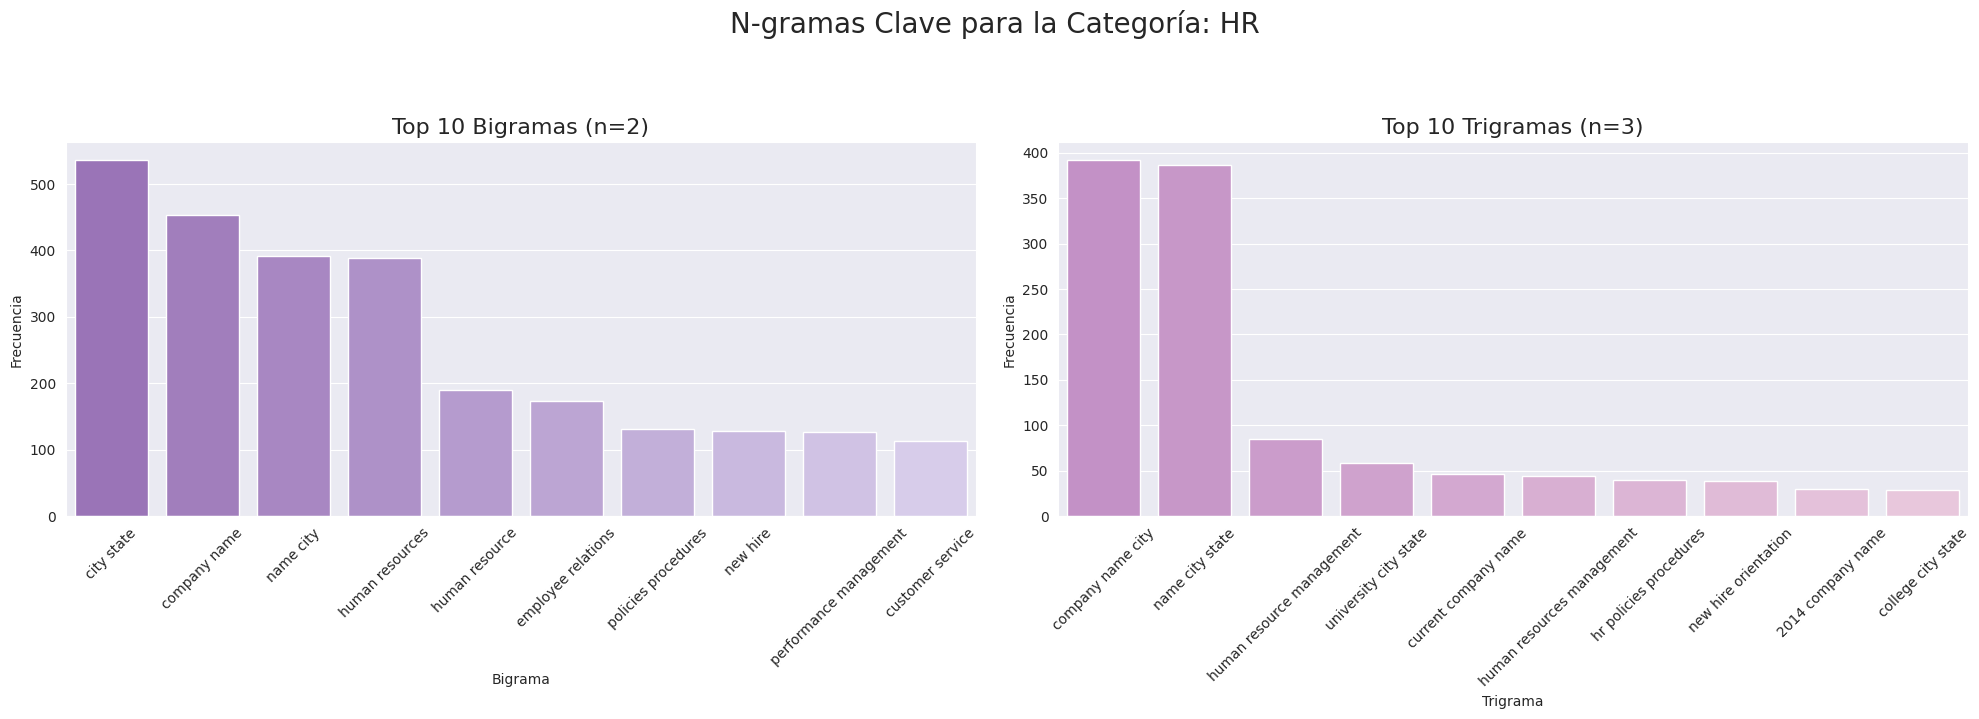

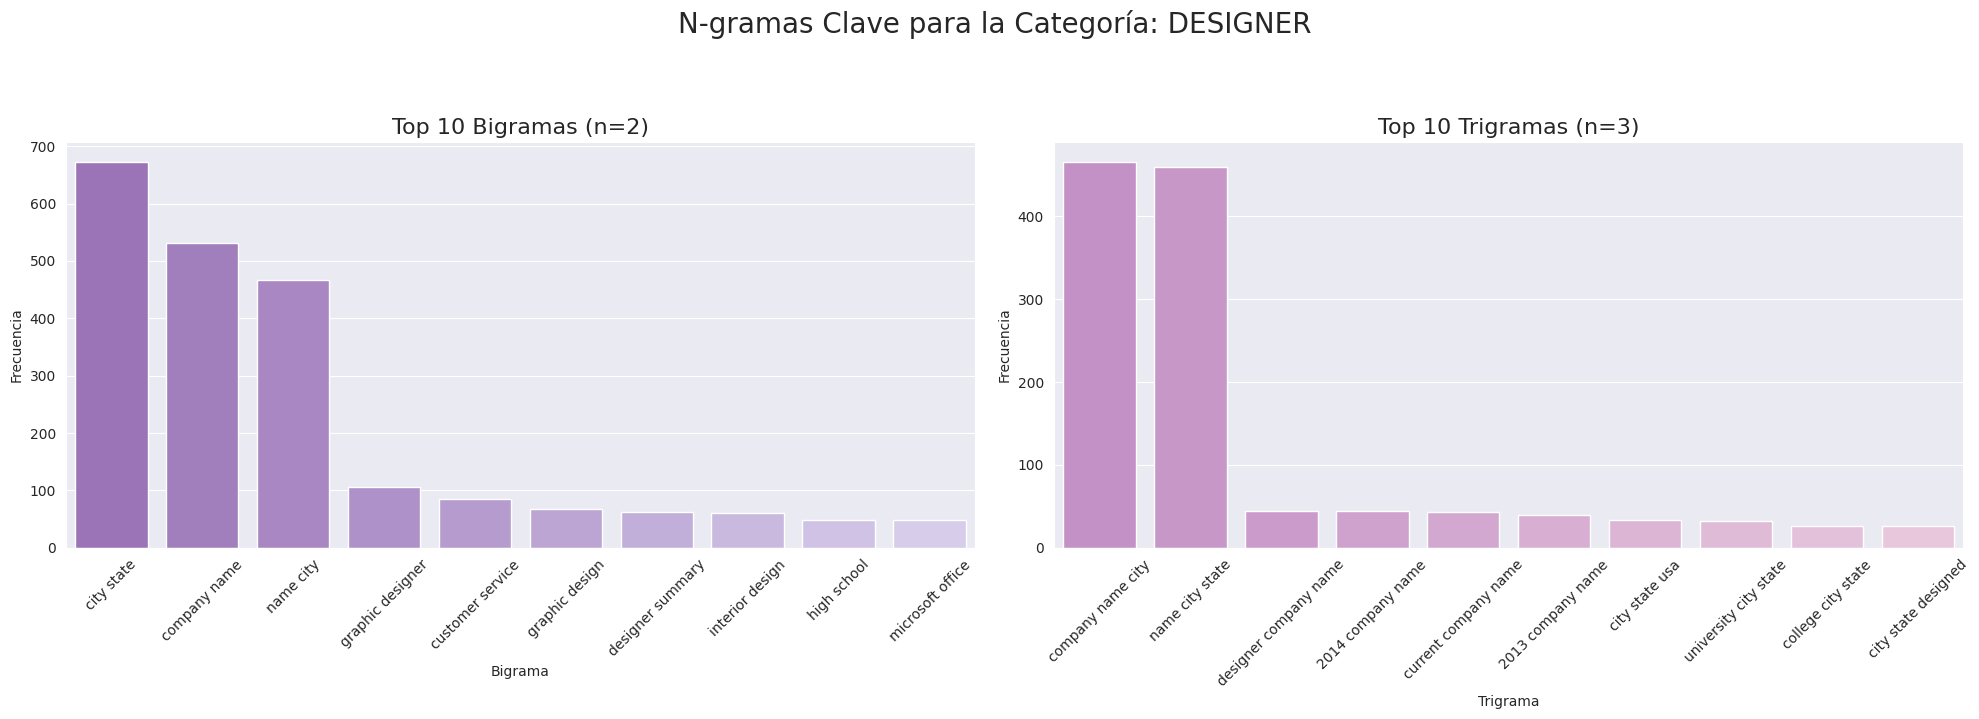

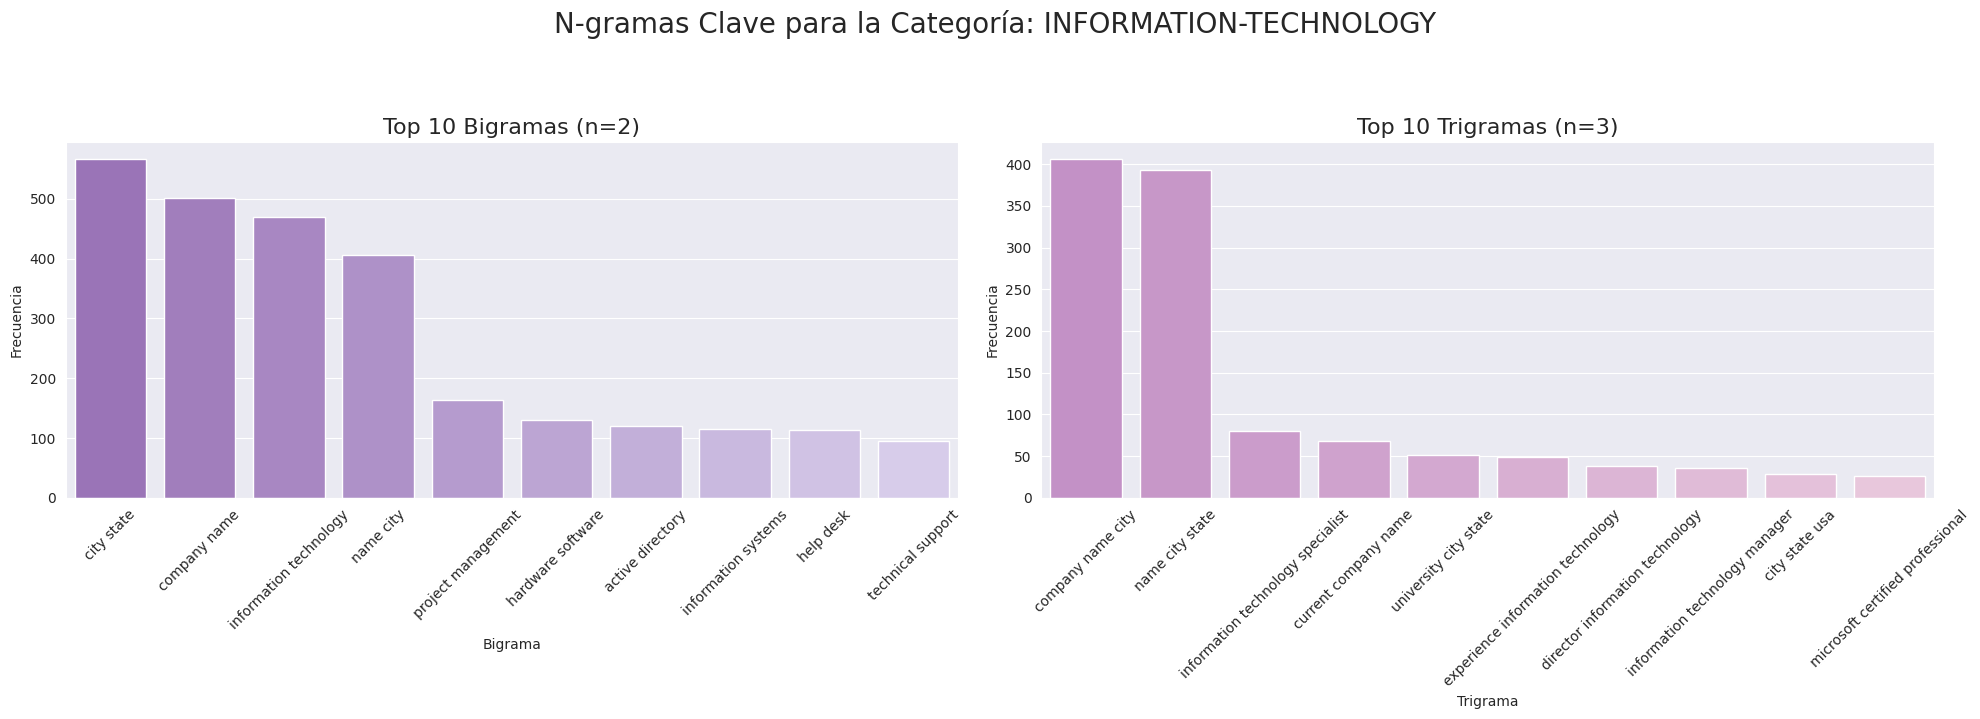

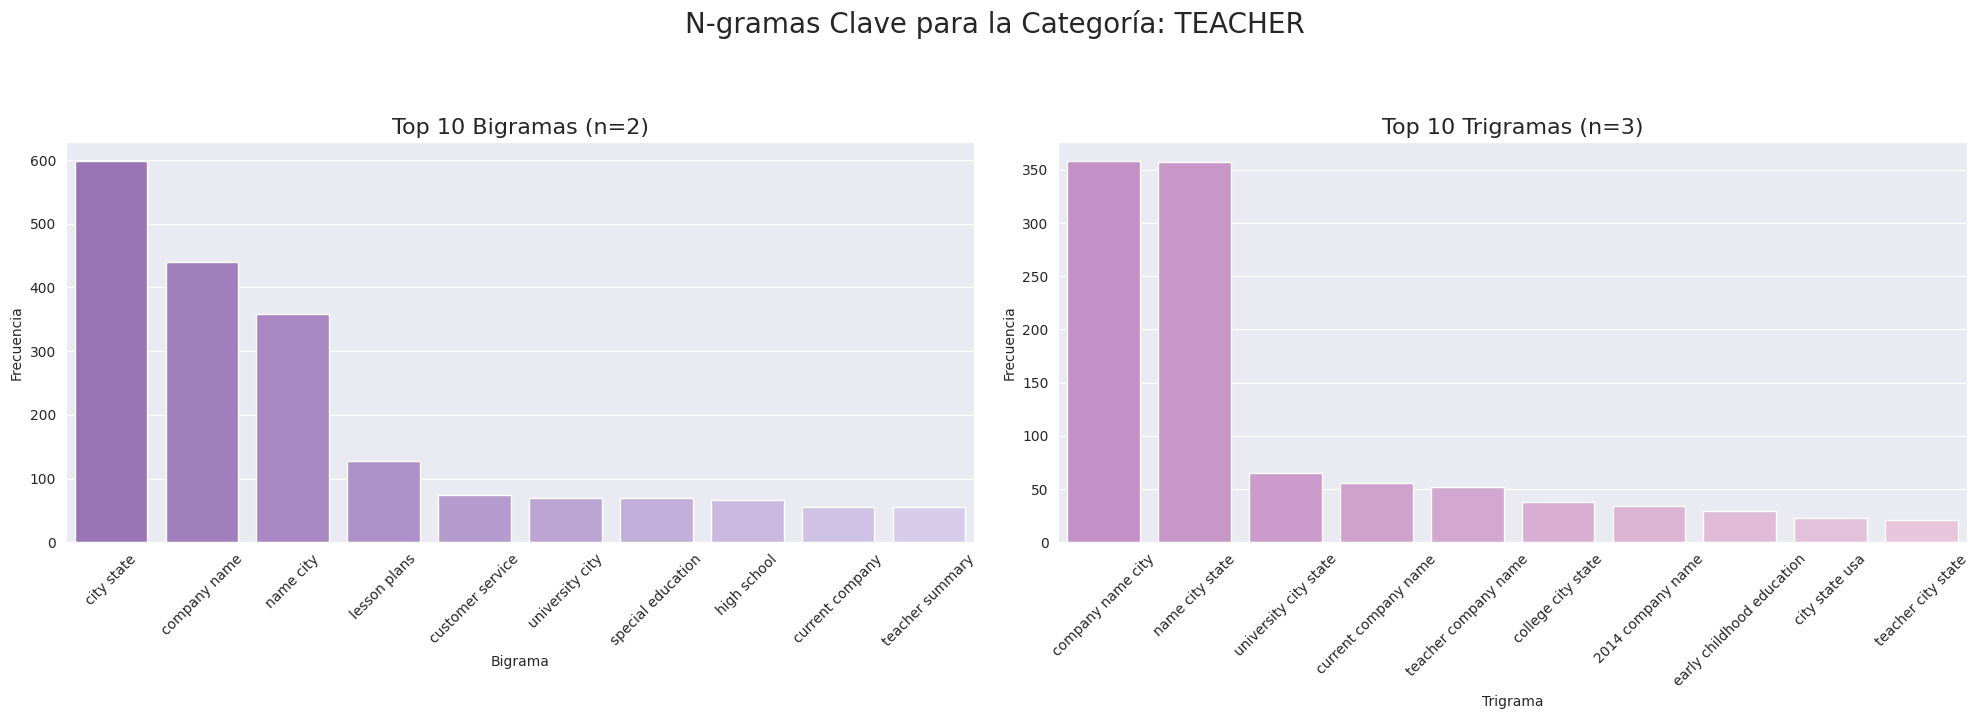

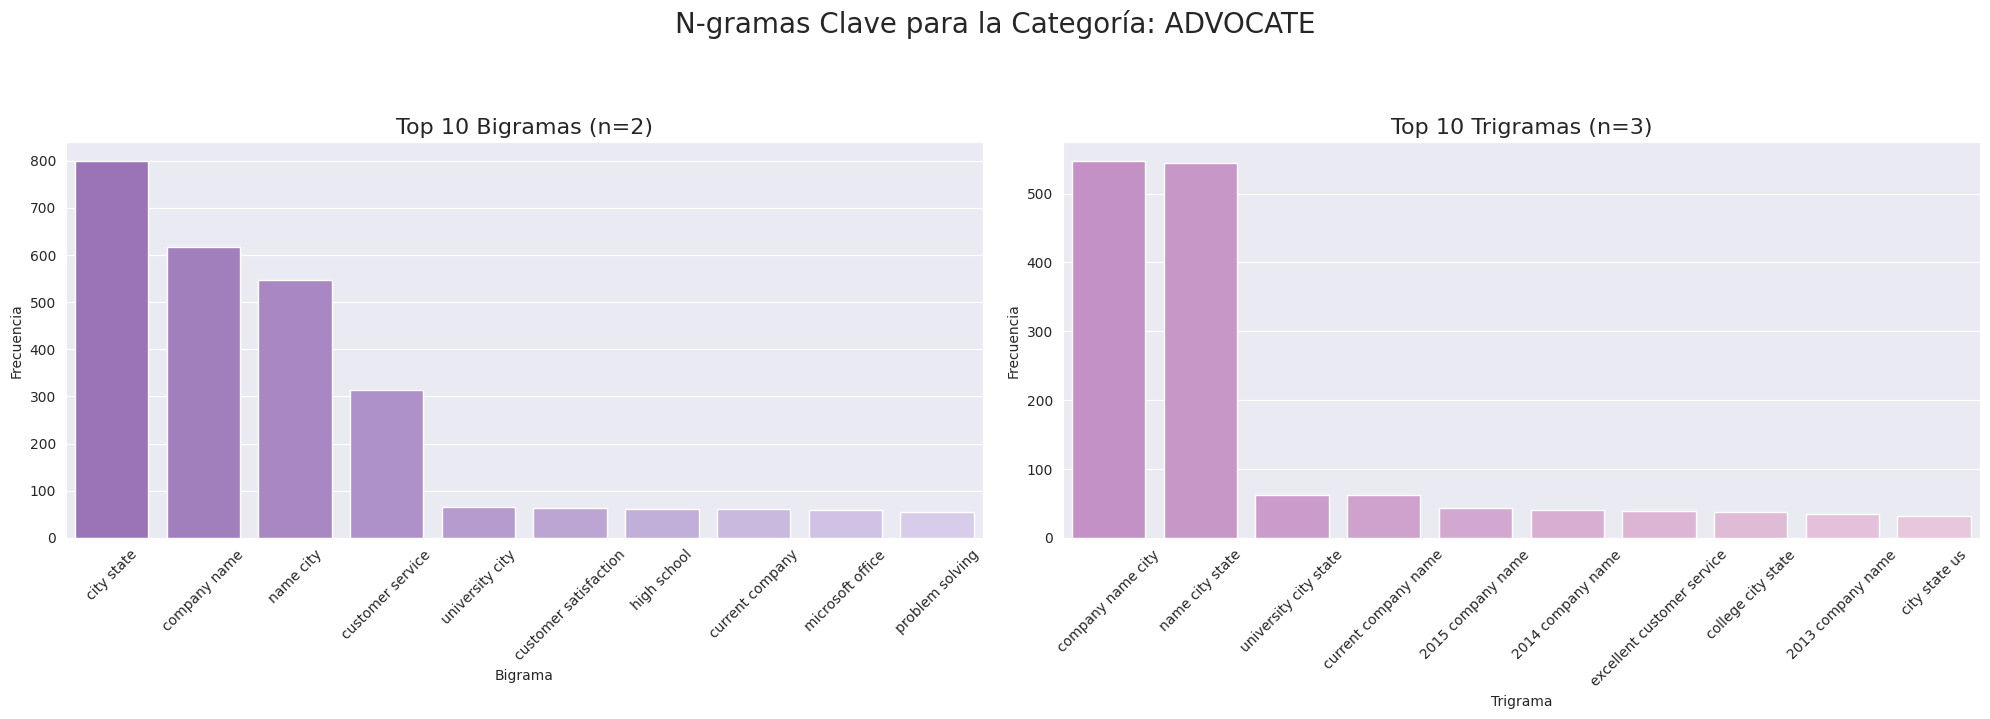

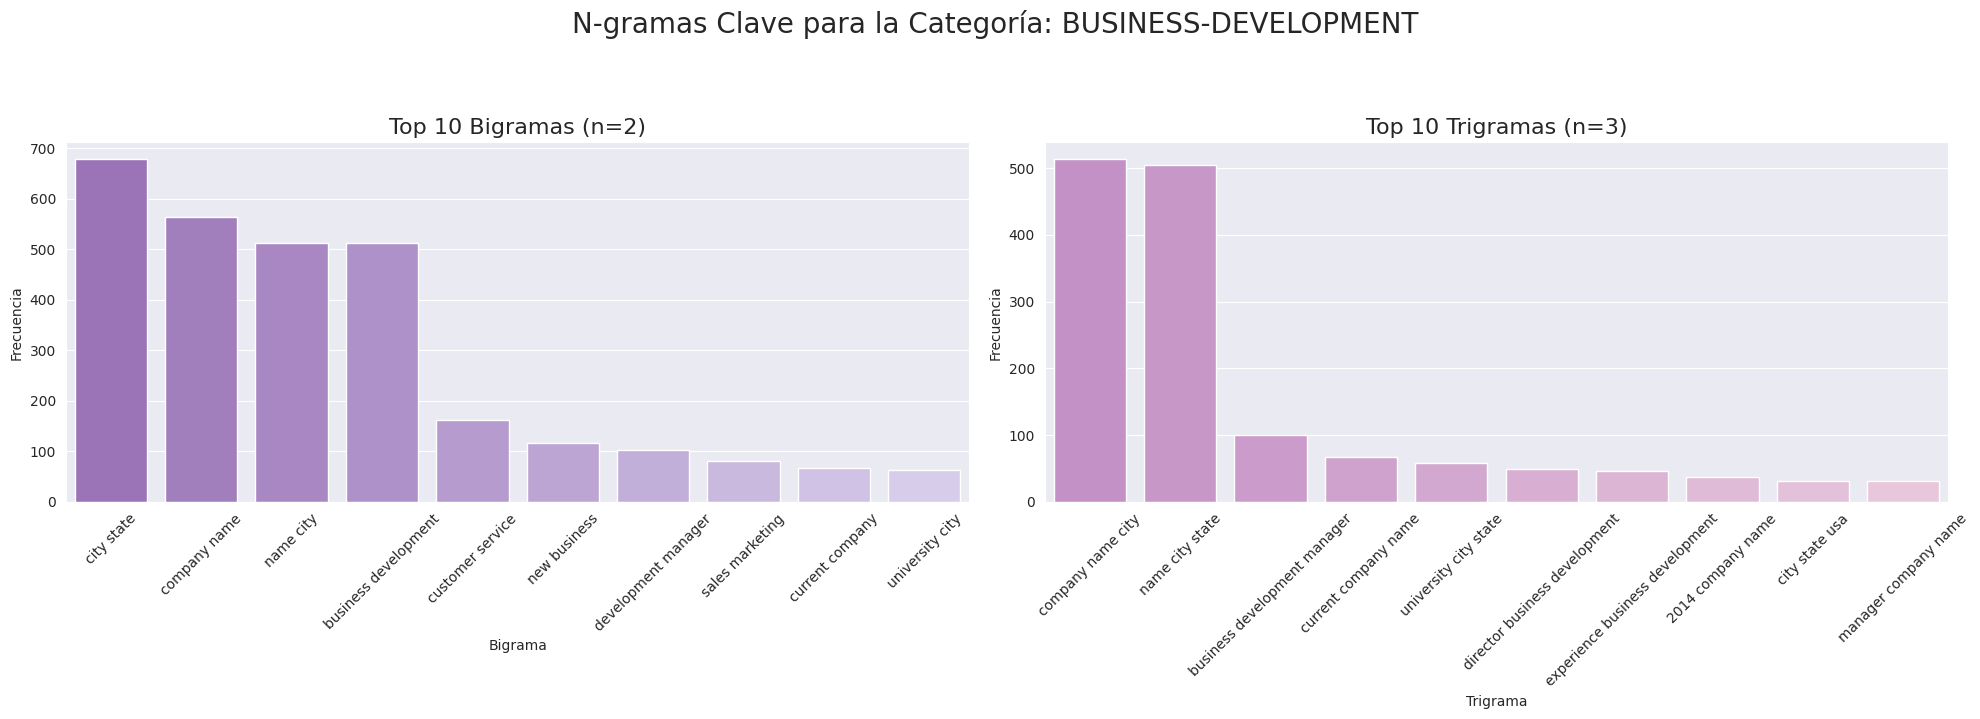

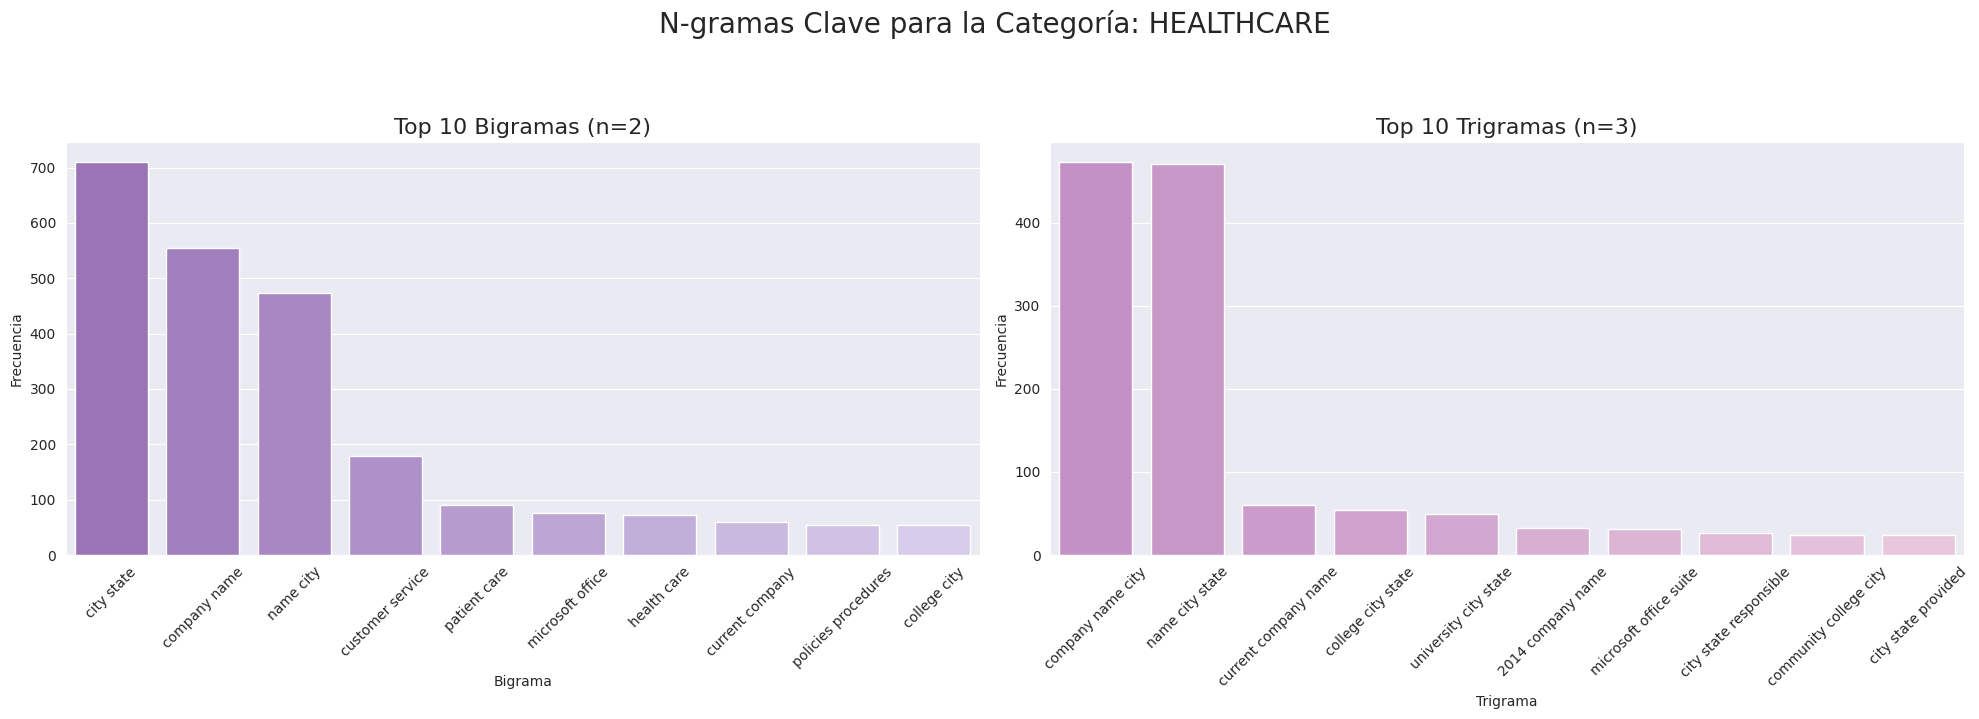

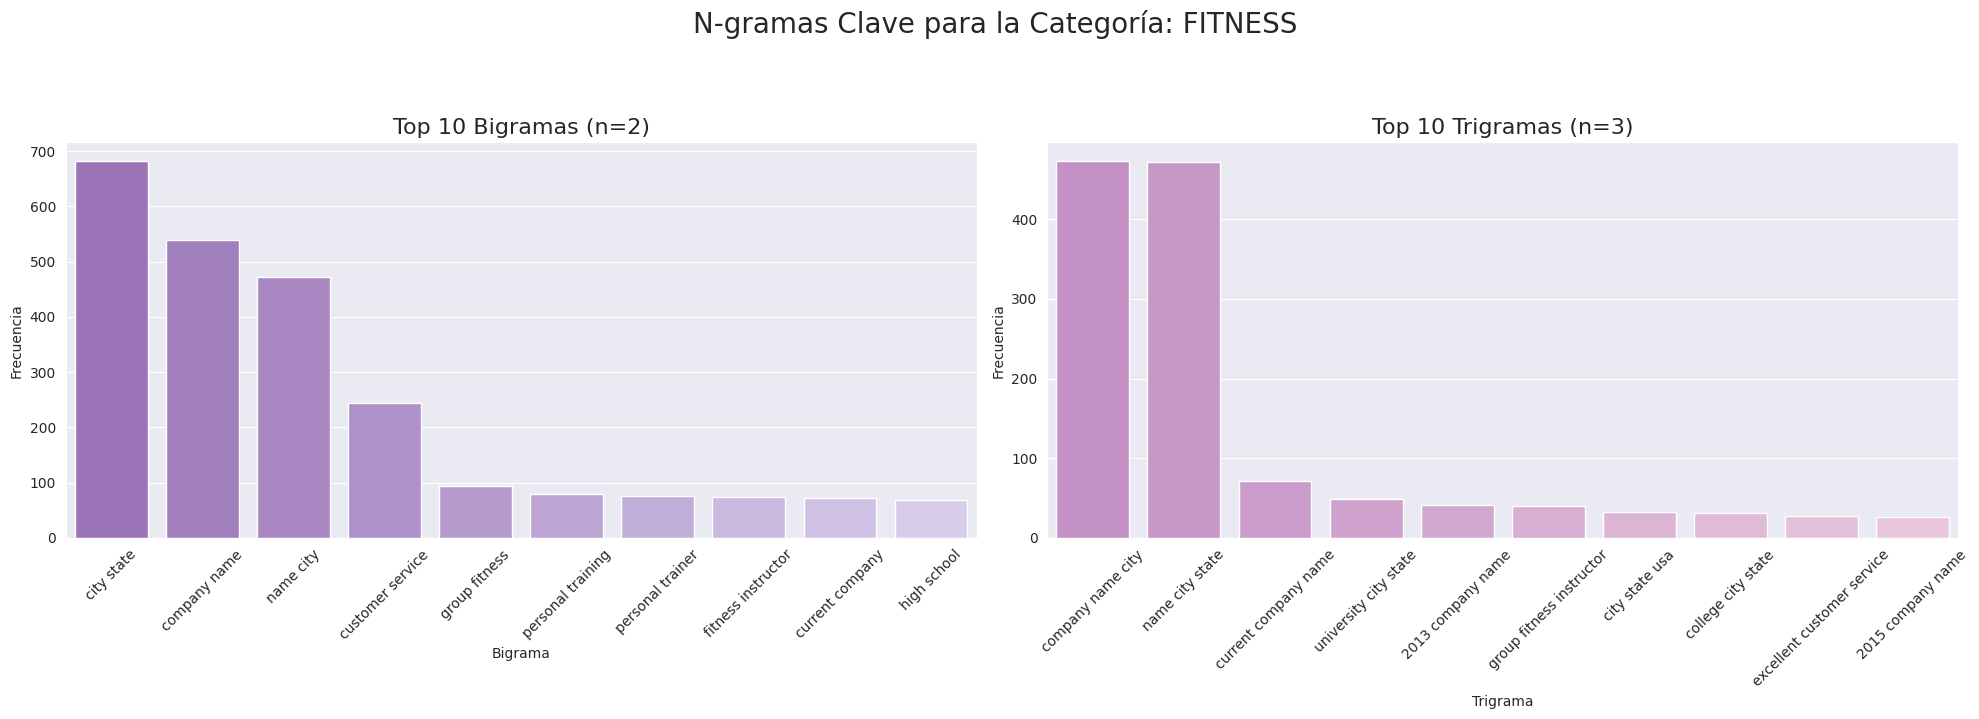

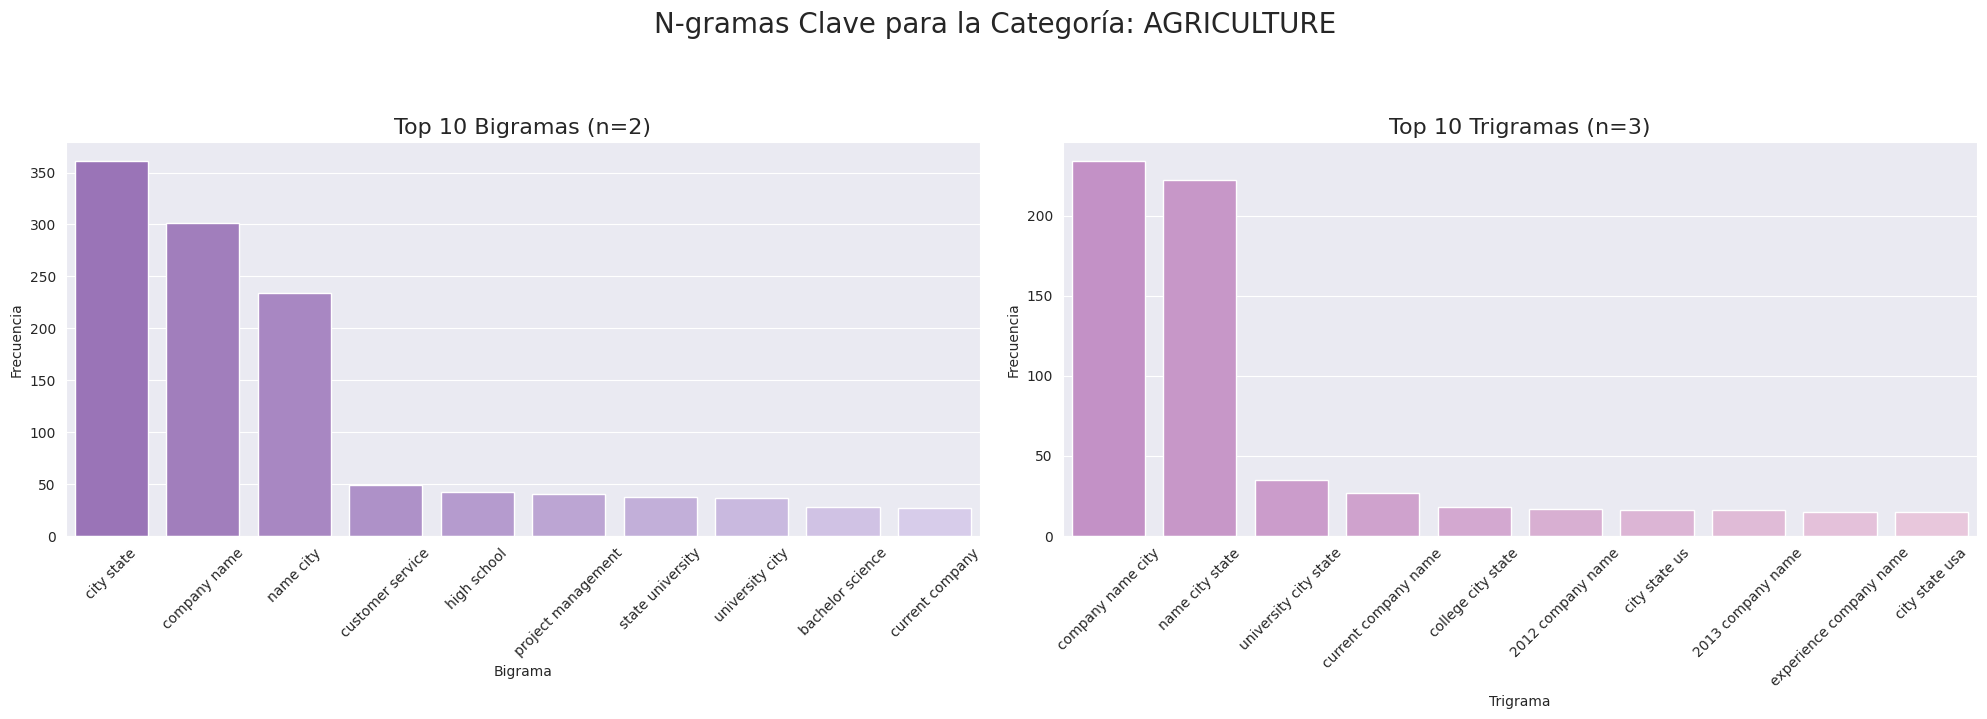

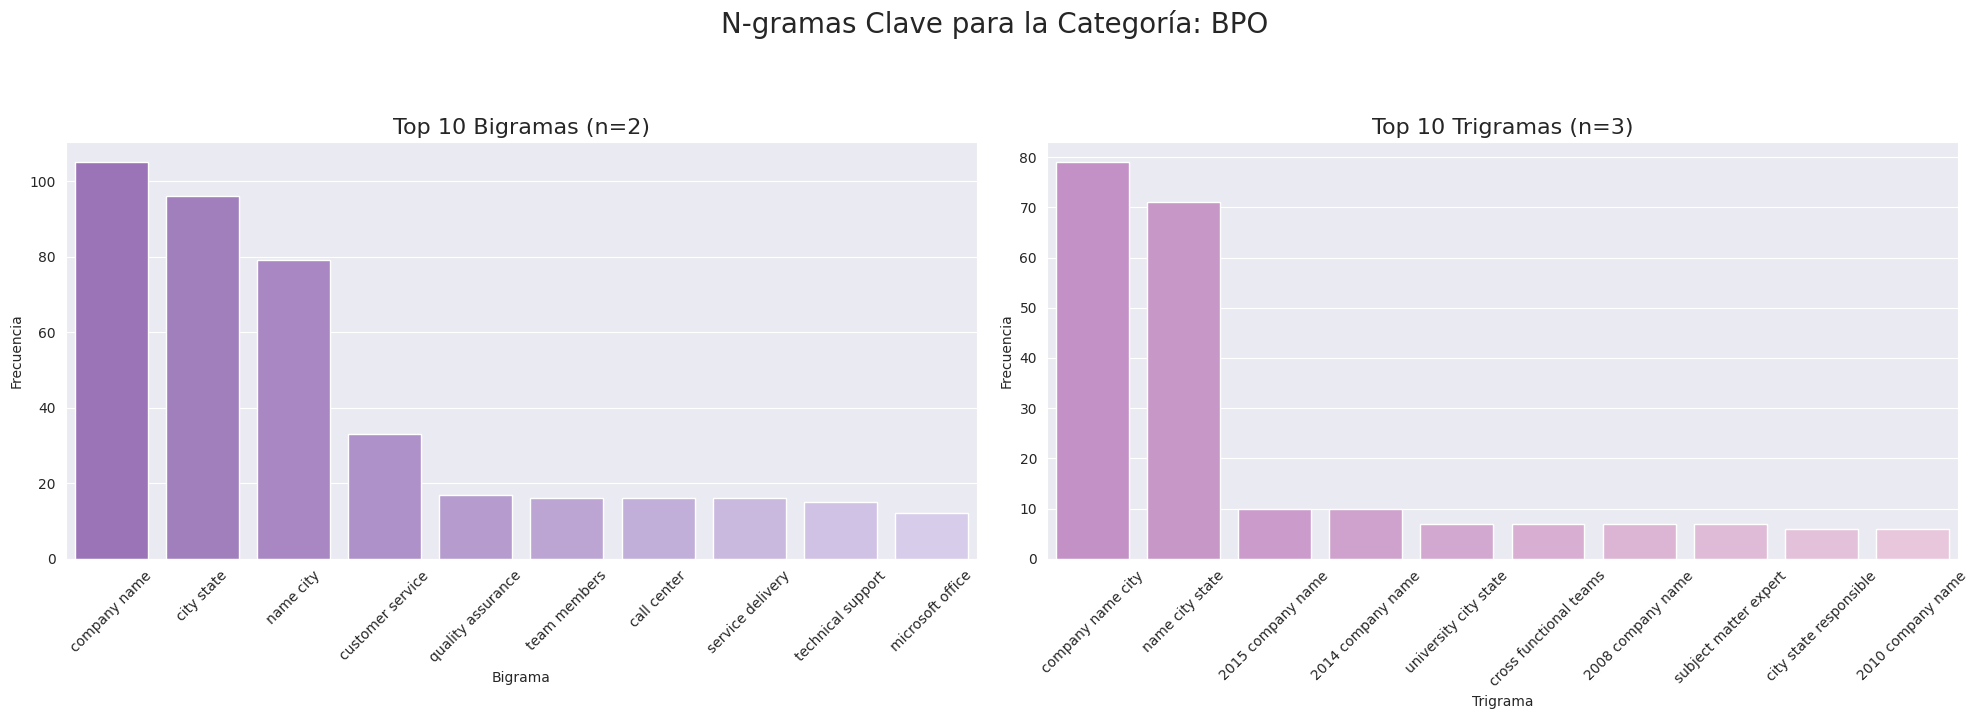

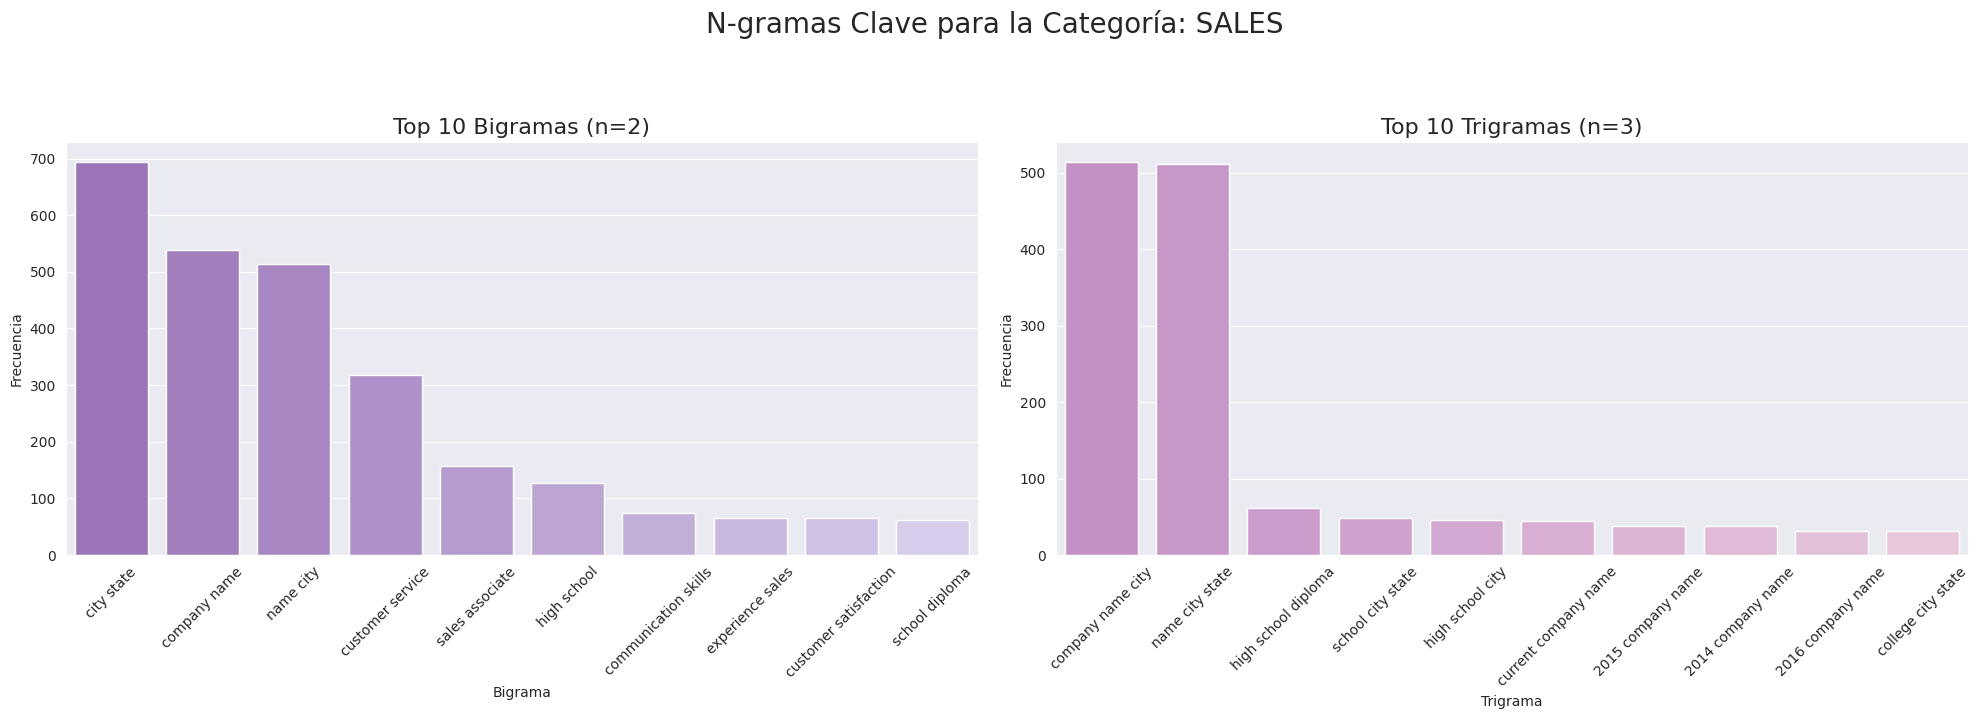

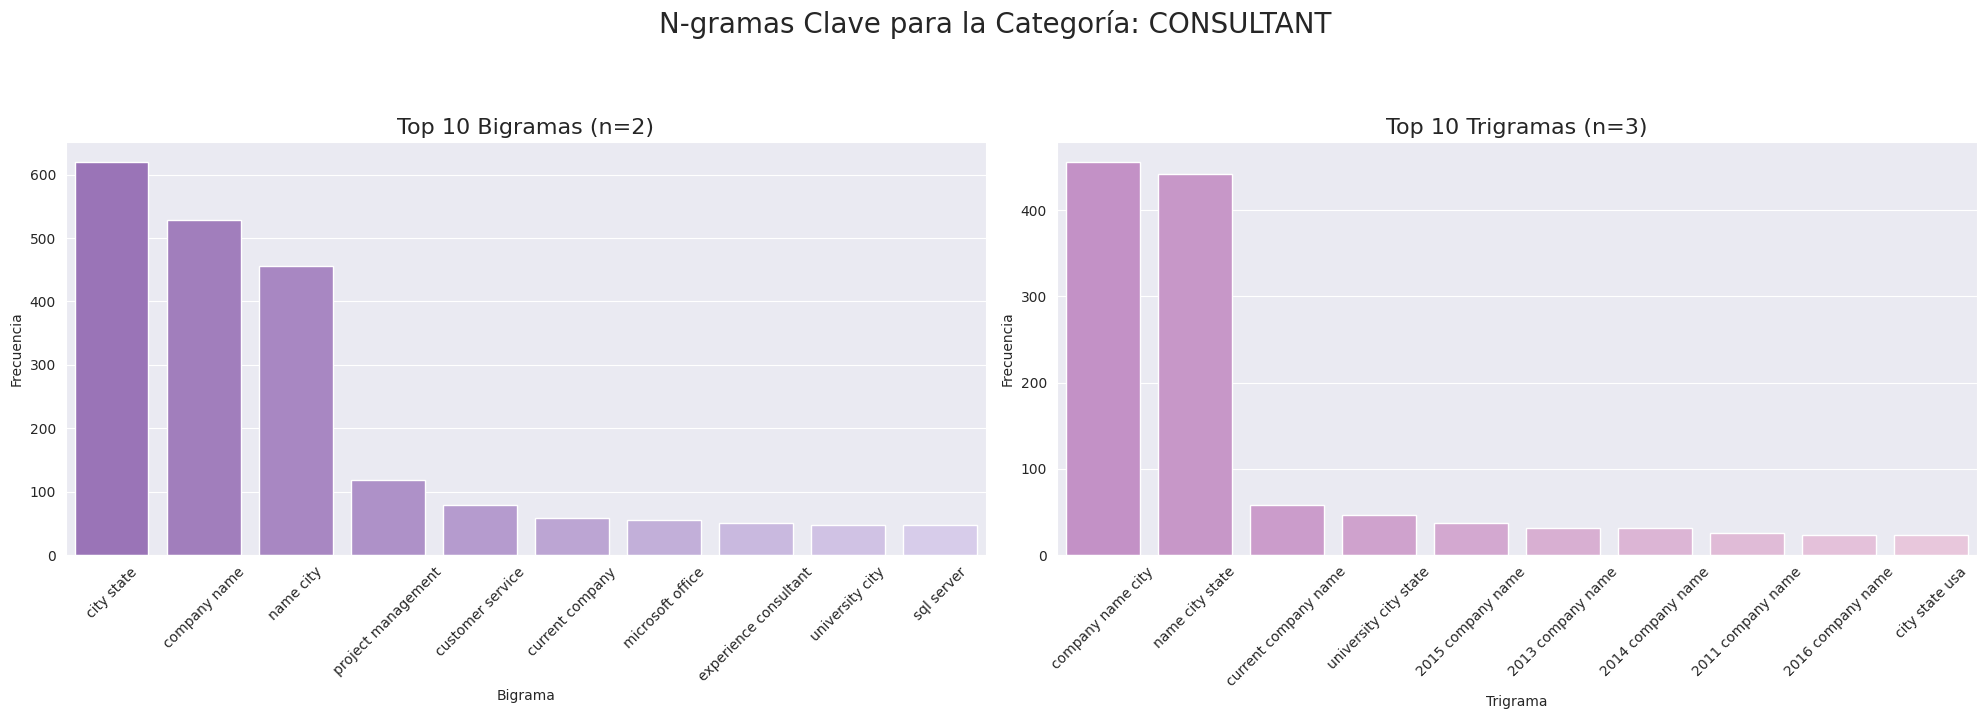

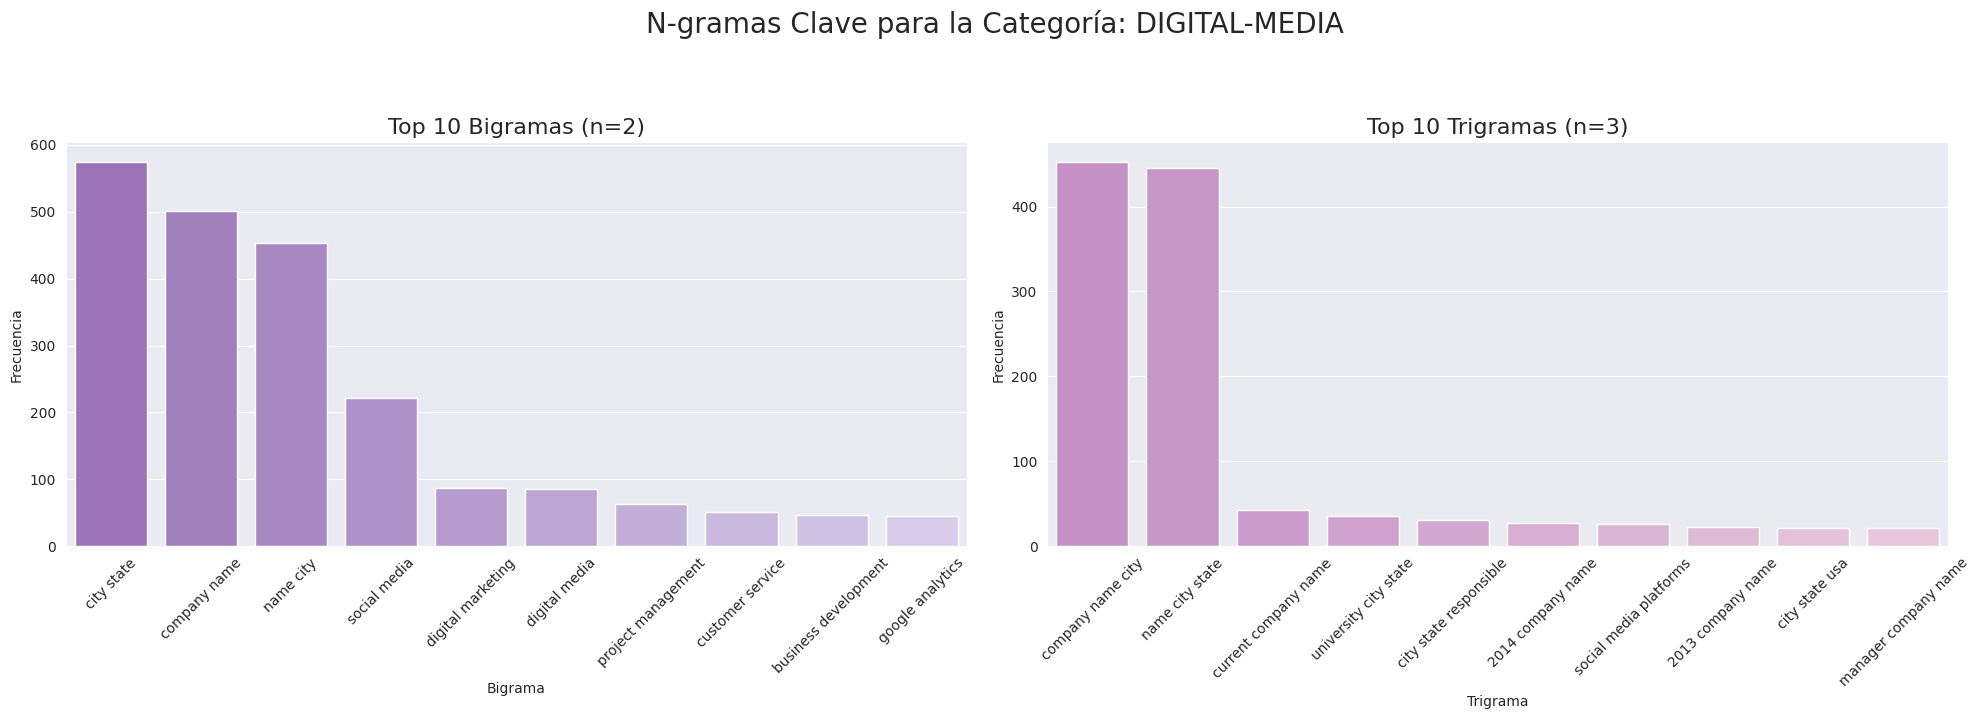

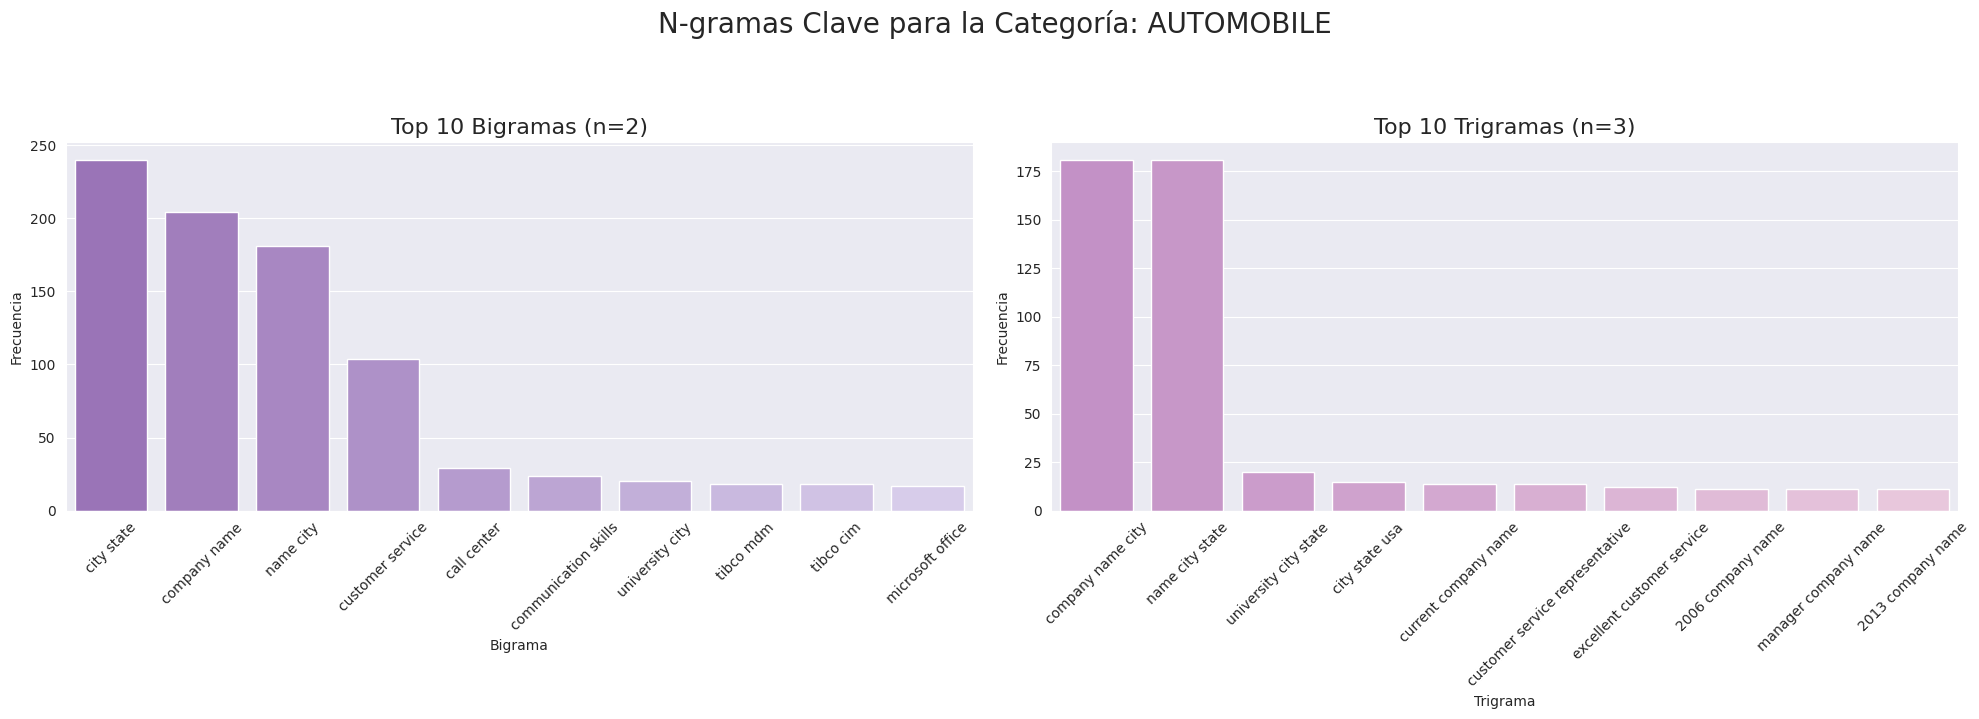

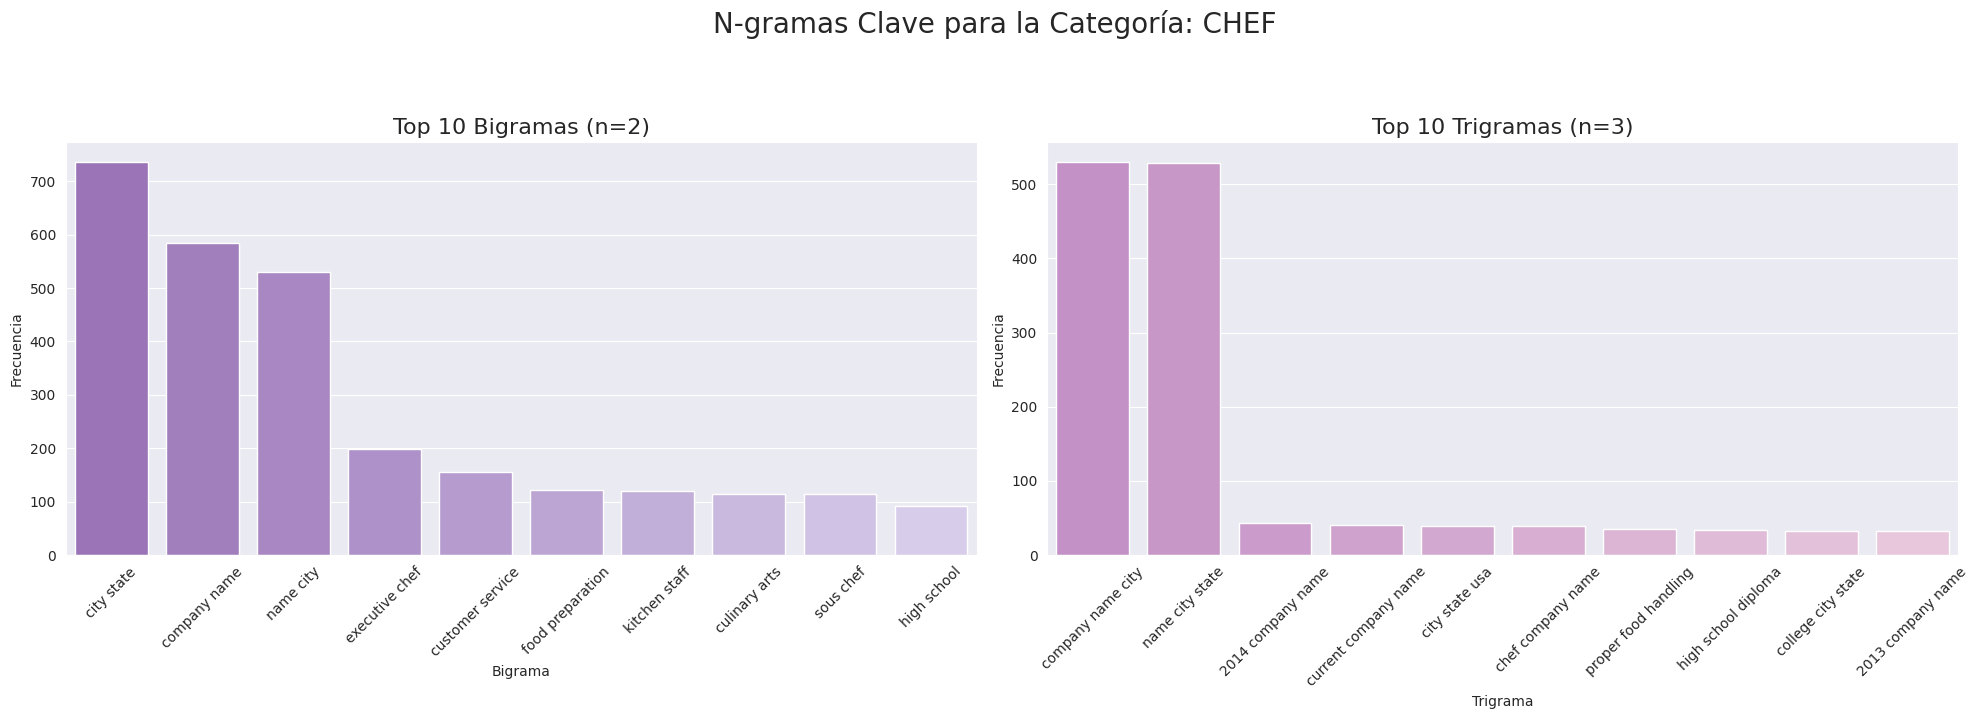

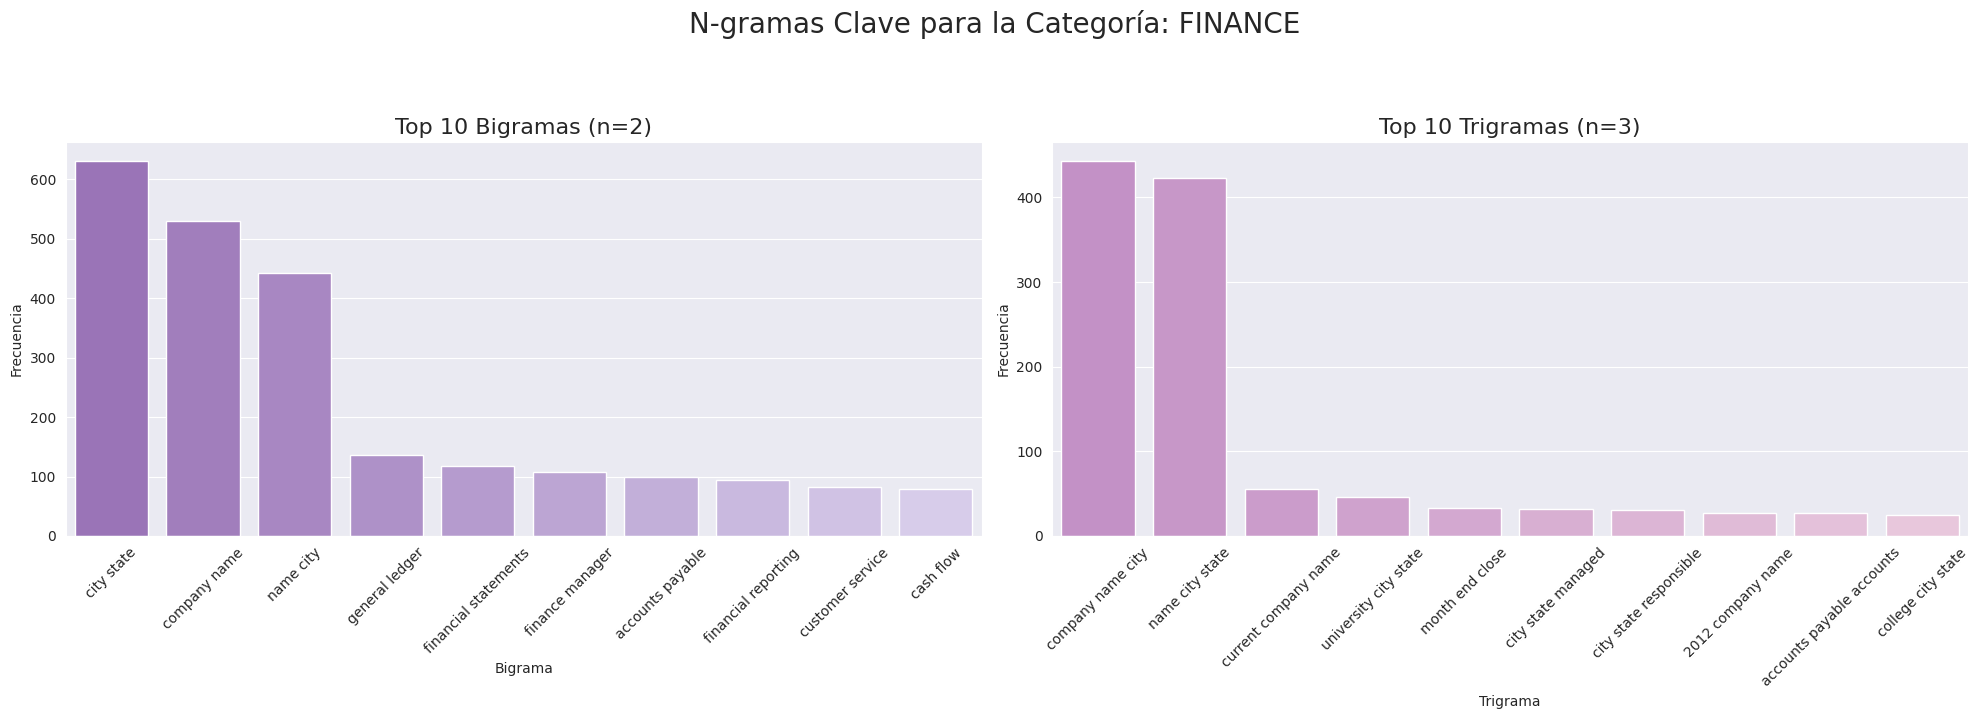

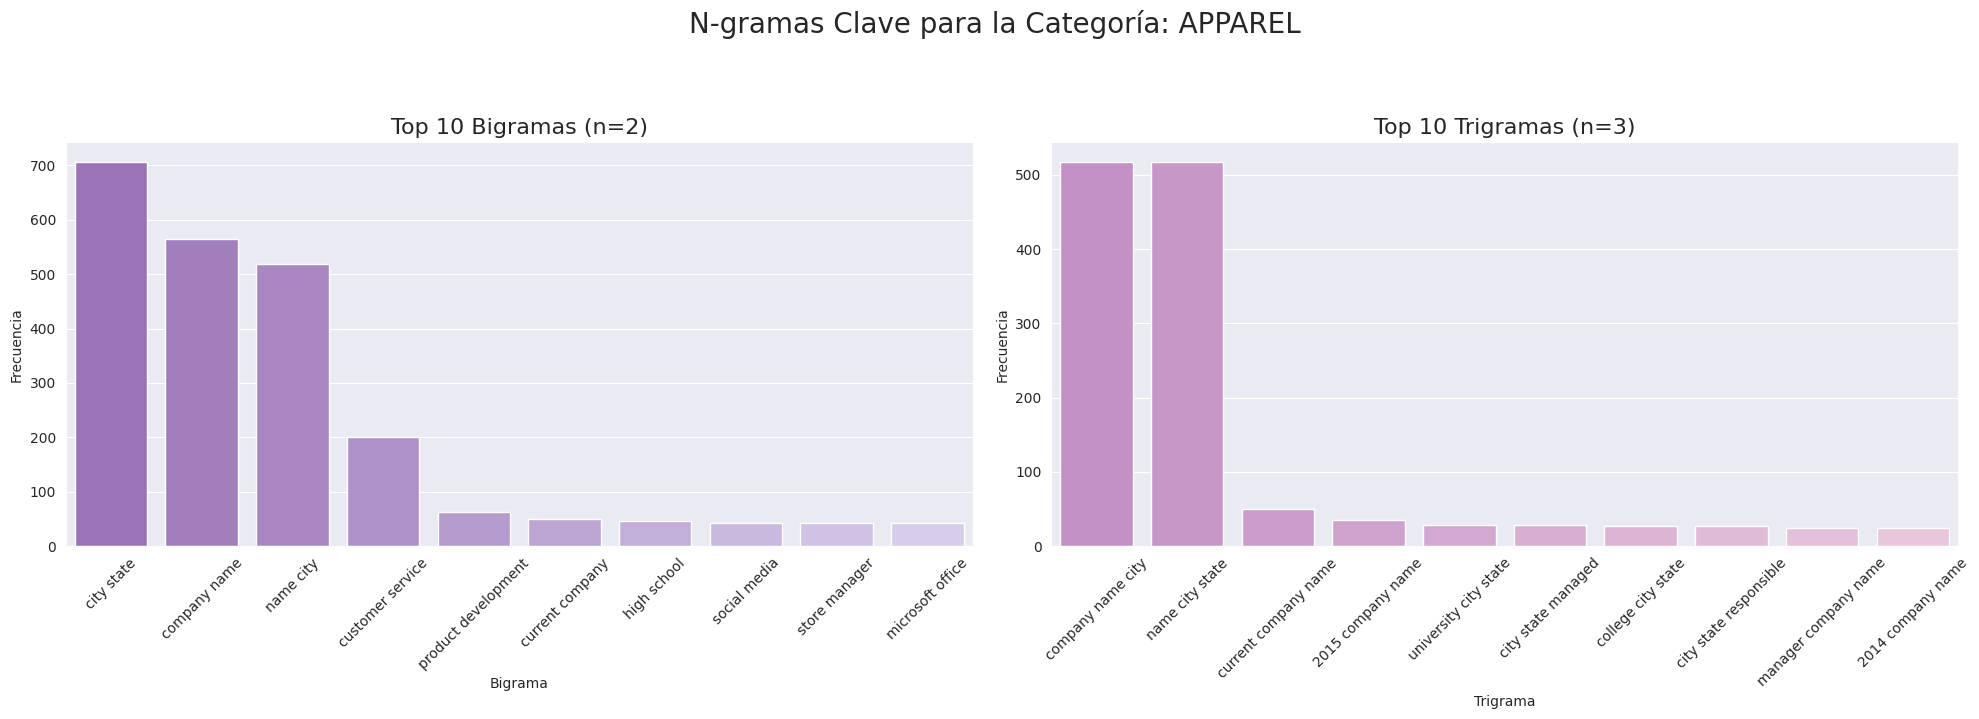

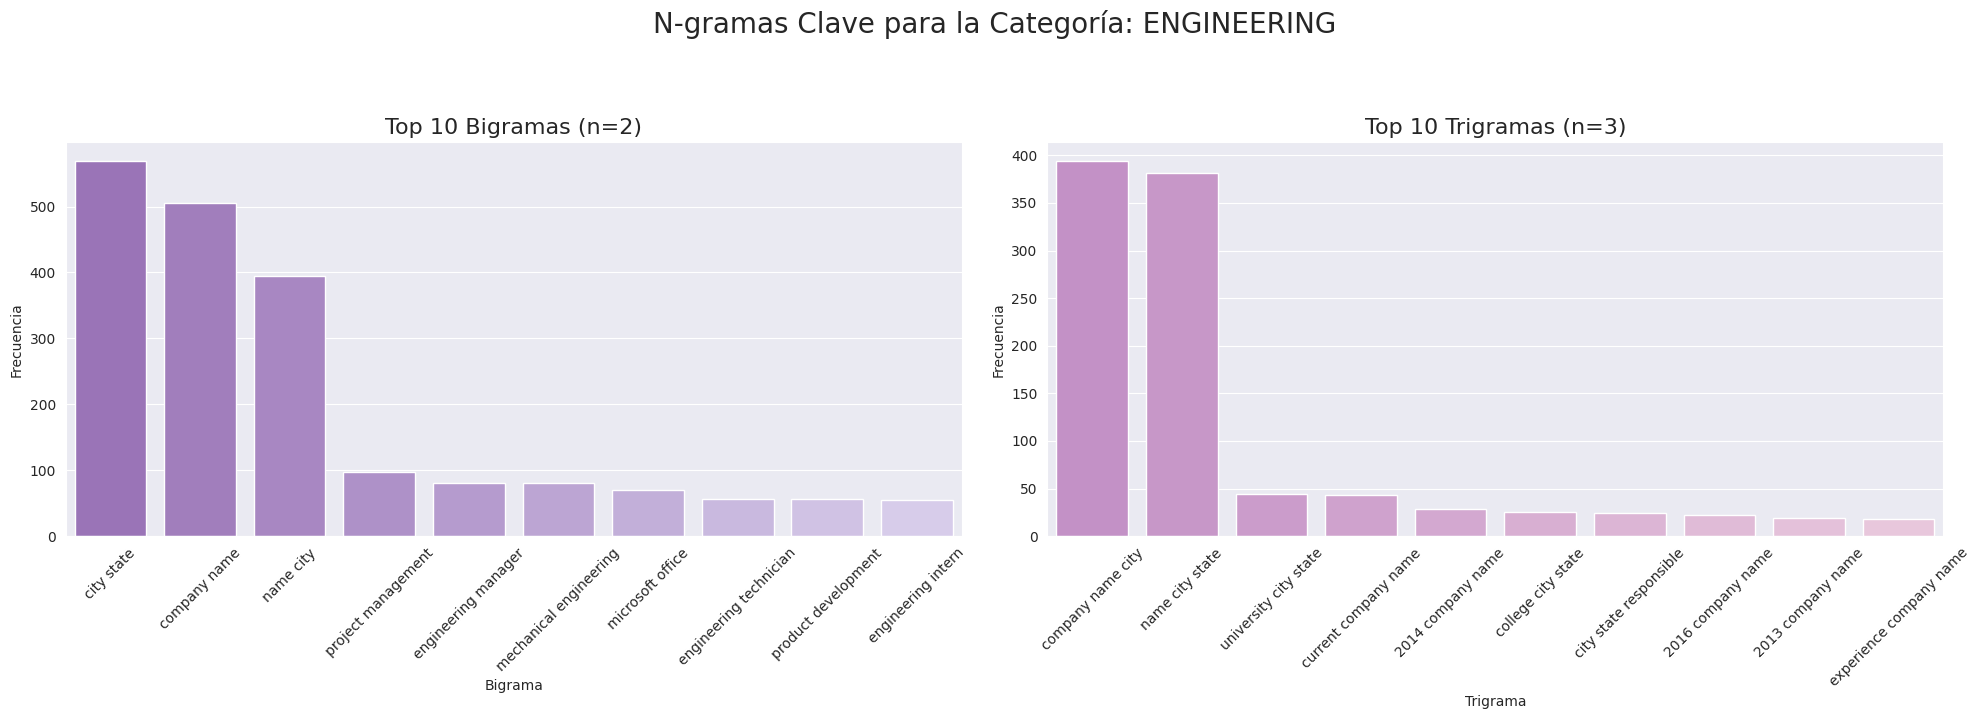

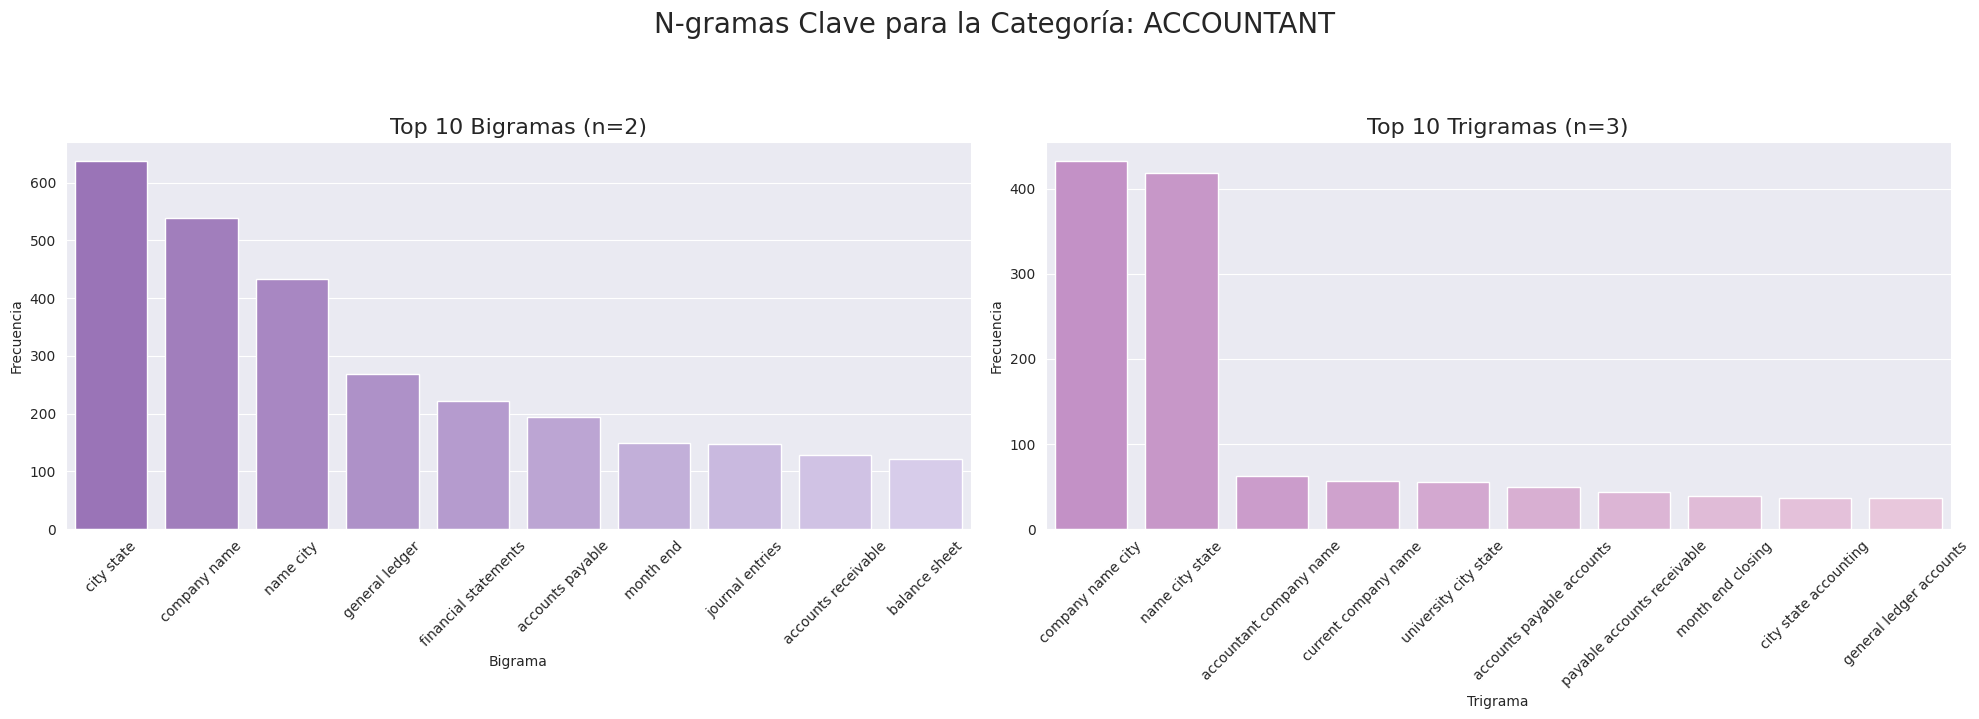

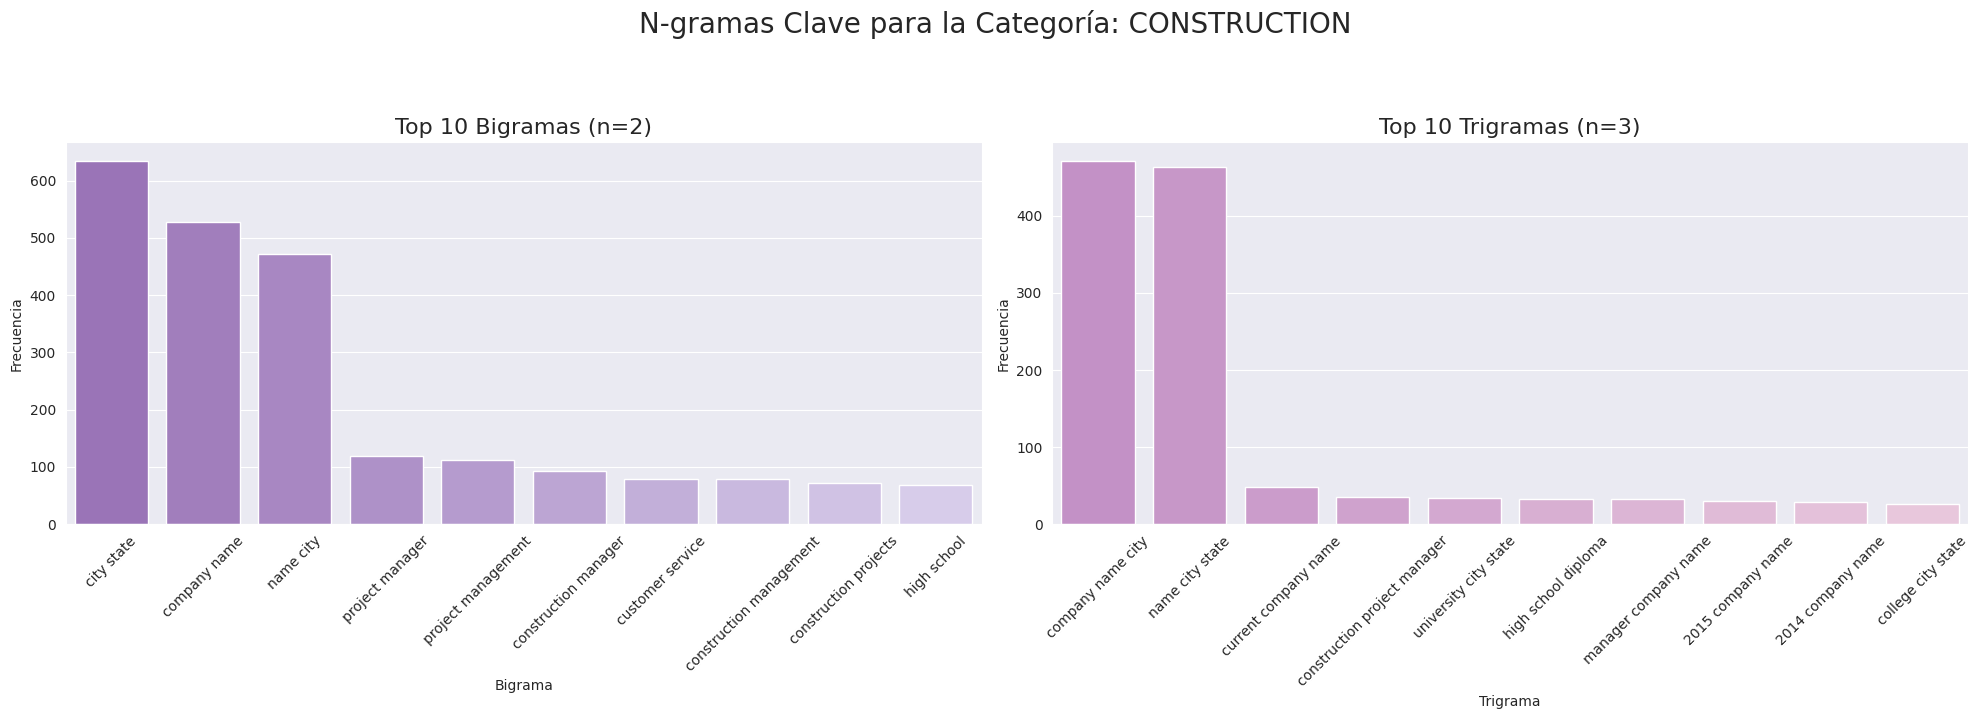

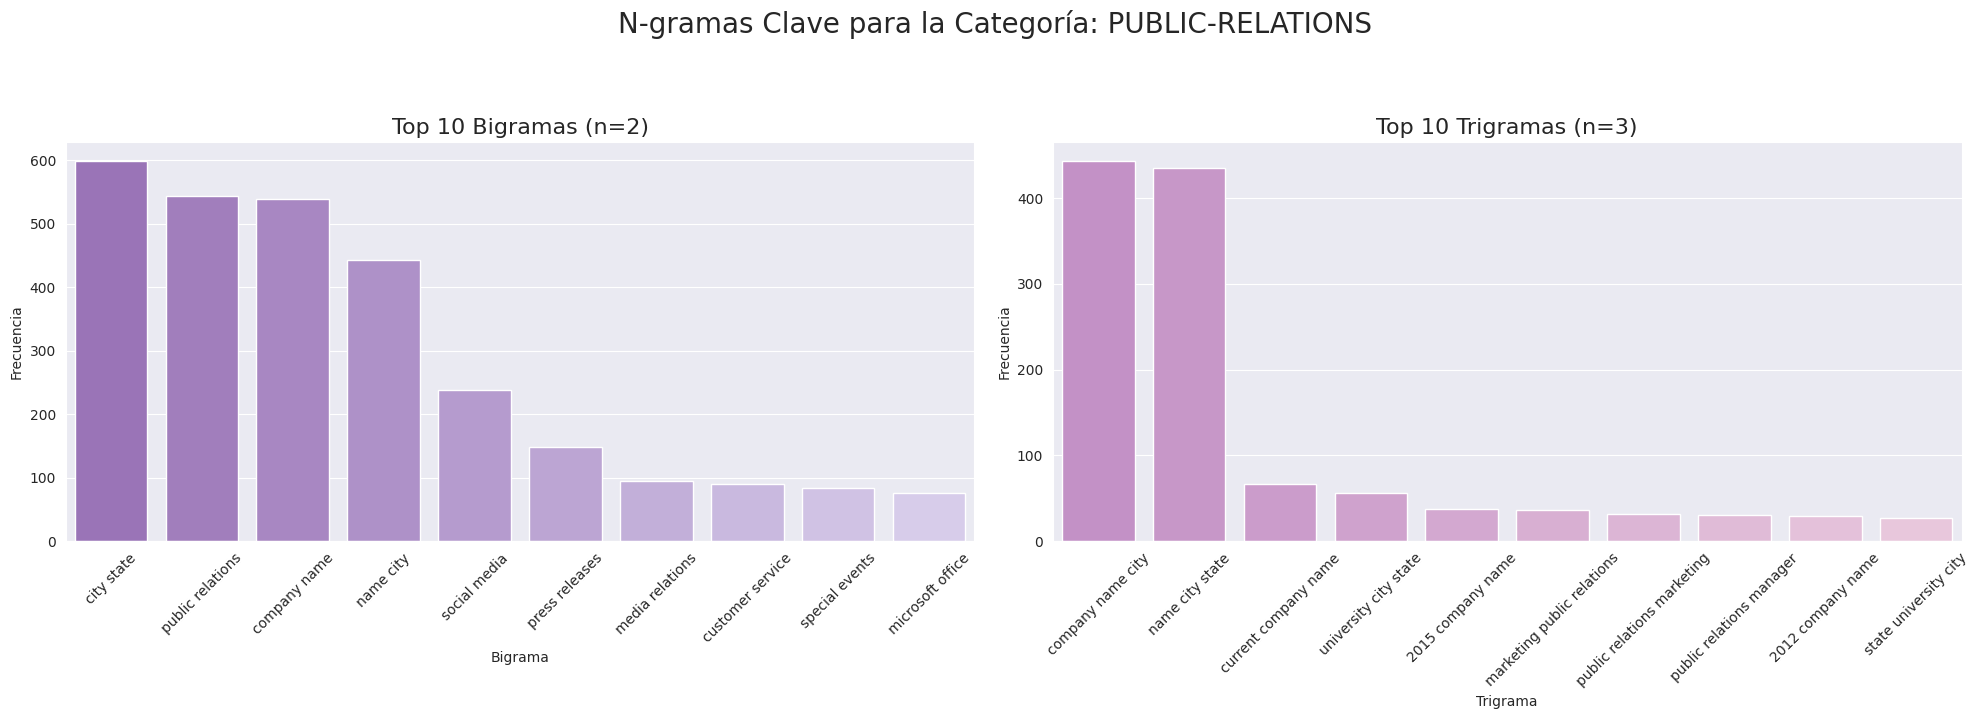

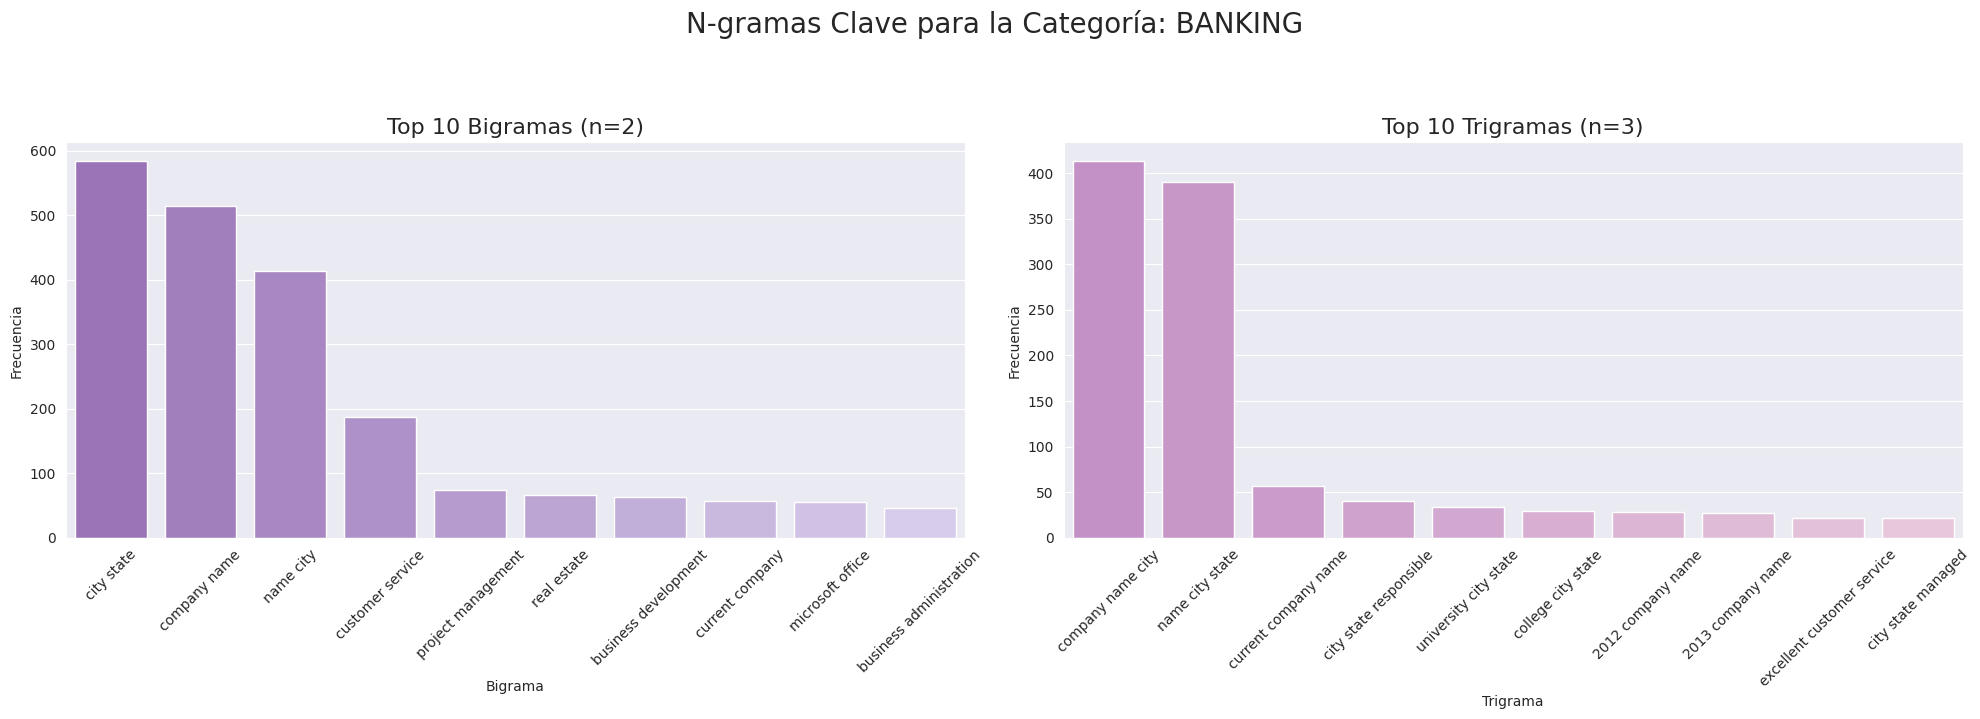

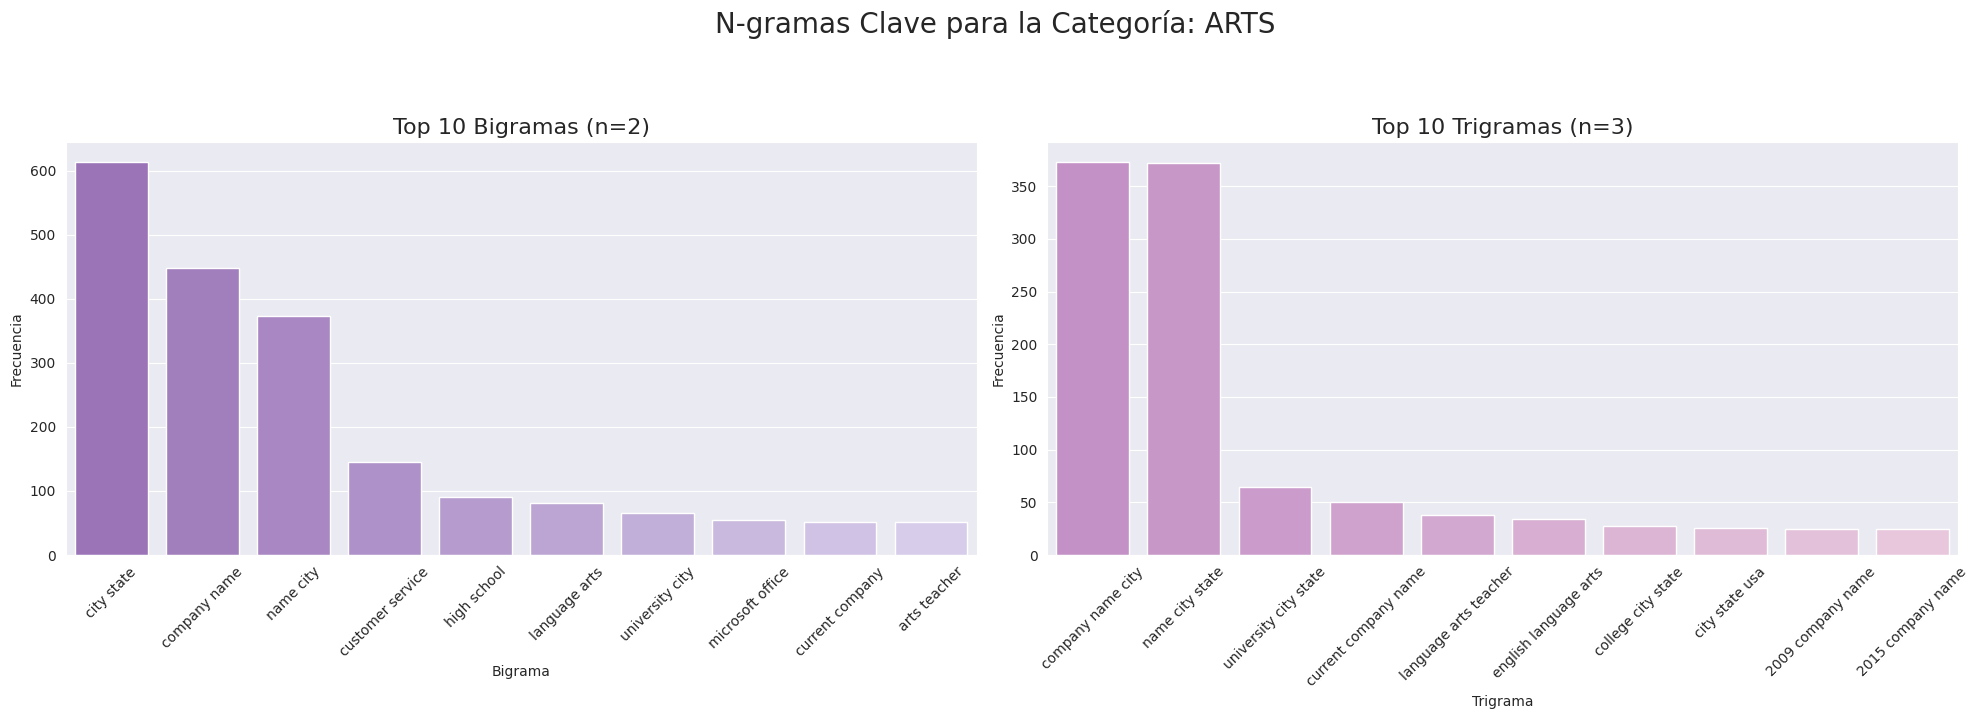

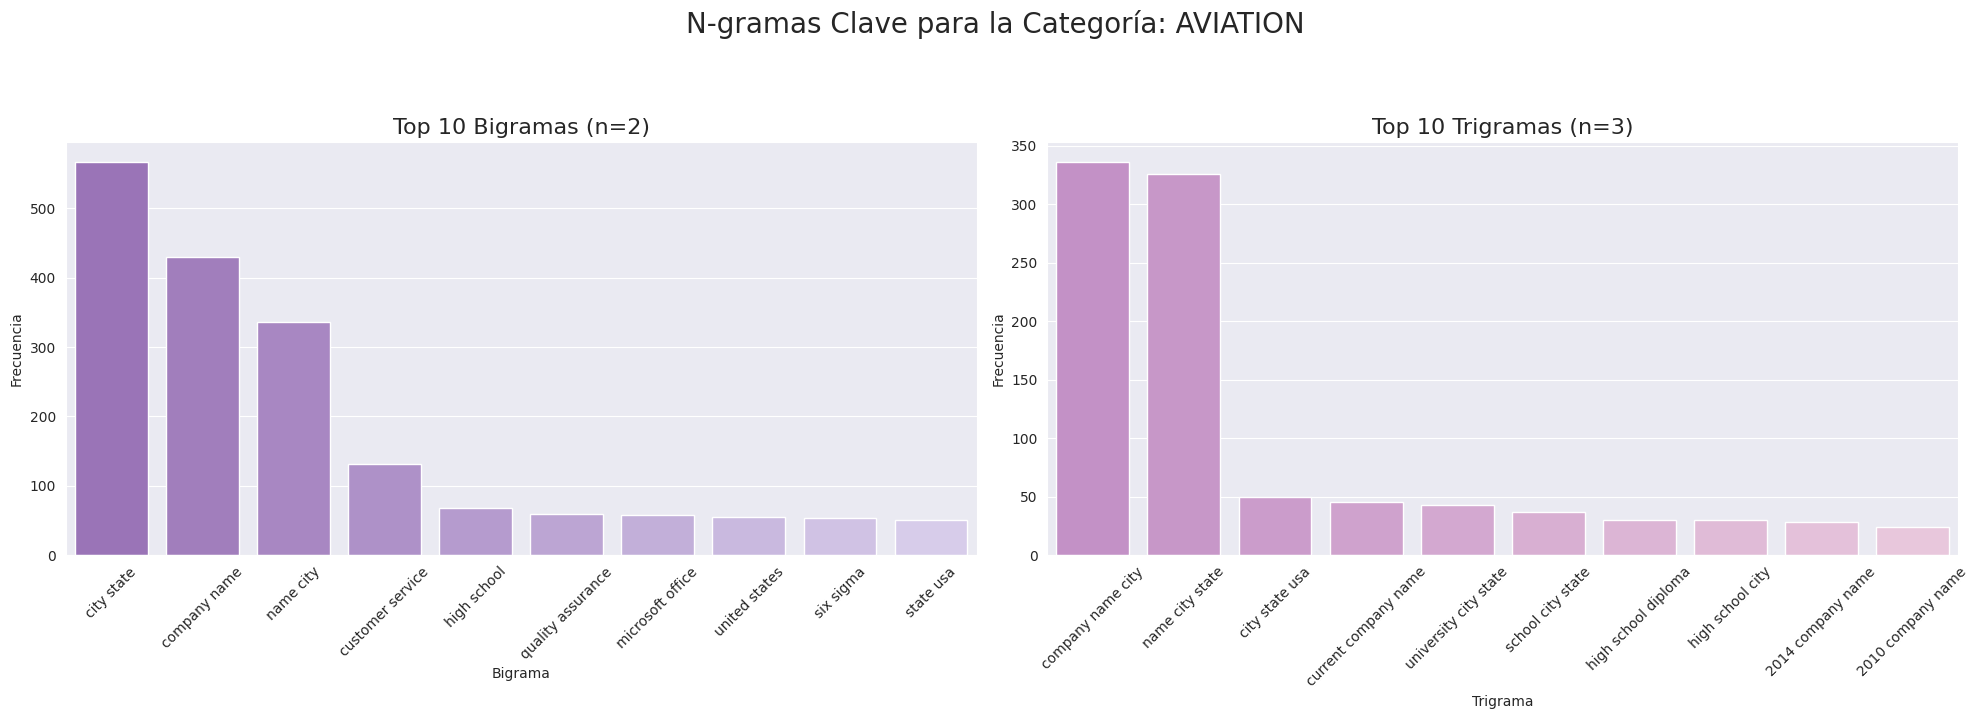

In [31]:
def plot_top_ngrams_by_category(df, col='clean_text_final', cat_col='job_category', top_n=10):
    
    categories = df[cat_col].unique()

    # Iterar sobre cada categoría para crear una figura individual por categoría
    for category in categories:
        # Filtrar el DataFrame para la categoría actual
        subset = df[df[cat_col] == category]
        
        # Unir el texto para el vectorizador
        text_data = subset[col].astype(str)
        
        # Crear la figura con dos subplots en una fila (Bigramas y Trigramas)
        fig, axes = plt.subplots(1, 2, figsize=(20, 7)) 
        
        # Título principal de la figura
        fig.suptitle(f'N-gramas Clave para la Categoría: {category}', fontsize=20, y=1.02)

        # --- Subplot 1: Bigramas (n=2) ---
        
        # 1. Vectorizar y contar Bigramas
        vectorizer_2 = CountVectorizer(ngram_range=(2, 2))
        X_2 = vectorizer_2.fit_transform(text_data)
        ngram_counts_2 = X_2.sum(axis=0)
        
        # 2. Extraer y ordenar
        ngrams_2 = [(ngram, ngram_counts_2[0, idx]) for ngram, idx in vectorizer_2.vocabulary_.items()]
        sorted_ngrams_2 = sorted(ngrams_2, key=lambda x: x[1], reverse=True)[:top_n]
        
        # 3. Preparar datos para el gráfico
        labels_2, freqs_2 = zip(*sorted_ngrams_2)
        
        # 4. Gráfico de Bigramas
        palette_2 = sns.blend_palette(["#9c69c2", "#D5C7EF"], n_colors=top_n)
        sns.barplot(x=list(labels_2), y=list(freqs_2), hue=list(labels_2), palette=palette_2, ax=axes[0], legend=False)
        axes[0].set_title(f'Top {top_n} Bigramas (n=2)', fontsize=16)
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].set_ylabel('Frecuencia')
        axes[0].set_xlabel('Bigrama')


        # --- Subplot 2: Trigramas (n=3) ---
        
        # 1. Vectorizar y contar Trigramas
        vectorizer_3 = CountVectorizer(ngram_range=(3, 3))
        X_3 = vectorizer_3.fit_transform(text_data)
        ngram_counts_3 = X_3.sum(axis=0)
        
        # 2. Extraer y ordenar
        ngrams_3 = [(ngram, ngram_counts_3[0, idx]) for ngram, idx in vectorizer_3.vocabulary_.items()]
        sorted_ngrams_3 = sorted(ngrams_3, key=lambda x: x[1], reverse=True)[:top_n]
        
        # 3. Preparar datos para el gráfico
        labels_3, freqs_3 = zip(*sorted_ngrams_3)
        
        # 4. Gráfico de Trigramas
        palette_3 = sns.blend_palette(["#CB88CF", "#EEC1DE"], n_colors=top_n) # Nueva paleta para distinguirlos
        sns.barplot(x=list(labels_3), y=list(freqs_3), hue=list(labels_3), palette=palette_3, ax=axes[1], legend=False)
        axes[1].set_title(f'Top {top_n} Trigramas (n=3)', fontsize=16)
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].set_ylabel('Frecuencia')
        axes[1].set_xlabel('Trigrama')

        
        plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajustar para el suptitle
        plt.show()


plot_top_ngrams_by_category(df, col='text', top_n=10)


#### Conclusiones Clave del Análisis de N-gramas

 1.  Distinción Clara entre Categorías Relacionadas

El análisis de N-gramas permitió diferenciar categorías que previamente mostraban solapamiento en el análisis de unigramas:

##### ACCOUNTANT vs. FINANCE
- **ACCOUNTANT** se centra en la ejecución operativa:  
  `accounts payable`, `accounts receivable`, `month end closing`, `journal entries`, `sales use tax`.
- **FINANCE** se enfoca en el reporte y la estrategia:  
  `financial statements`, `general ledger`, `certified public accountant`, `month end close`.

##### INFORMATION-TECHNOLOGY vs. ENGINEERING
- **INFORMATION-TECHNOLOGY** se orienta a infraestructura y soporte:  
  `active directory`, `help desk`, `disaster recovery`, `local area network`.
- **ENGINEERING** se enfoca en desarrollo técnico y calidad:  
  `mechanical engineering`, `statistical process control`, `root cause analysis`, `product development`.

---

 2.  Identificación de Habilidades Específicas 

Cada categoría laboral presenta un conjunto de N-gramas altamente predictivos que definen su "ADN de habilidades":

| Categoría         | Bigrama/Trigrama Más Predictivo                     | Tipo de Habilidad                         |
|-------------------|-----------------------------------------------------|-------------------------------------------|
| HR                | `human resources`, `employee relations`, `policies procedures` | Legal y de personal                       |
| DESIGNER          | `graphic design`, `interior design`, `adobe creative suite` | Herramientas y subdisciplina              |
| TEACHER           | `lesson plans`, `special education`, `early childhood education` | Metodología educativa y especialidad      |
| CHEF              | `executive chef`, `food preparation`, `proper food handling` | Rango y seguridad alimentaria             |
| FITNESS           | `group fitness`, `personal training`, `certified personal trainer` | Certificación y tipo de servicio          |
| PUBLIC-RELATIONS  | `public relations`, `social media`, `press releases` | Tácticas de comunicación                  |
| AVIATION          | `aviation maintenance`, `lean six sigma`, `security clearance` | Especialización y certificaciones         |
| BPO               | `quality assurance`, `call center`, `subject matter expert` | Terminología de servicio tercerizado      |

---

 3.  Detección de Ruido Residual o Genérico

A pesar de la limpieza inicial, persisten algunos N-gramas estructurales o genéricos que deben filtrarse antes del modelado, especialmente en enfoques como TF-IDF o Word2Vec:

| N-grama                    | Impacto                                                                 | 
|---------------------------|-------------------------------------------------------------------------|
| `high school`, `high school diploma` | Aparece en roles menos técnicos y CVs de entrada. Es un proxy de nivel educativo. | 
| `microsoft office`, `microsoft office suite` | Habilidad universal, no distintiva. Presente en casi todas las categorías. | 
| `bachelor science`, `bachelor arts` | Términos genéricos de educación que no distinguen categoría. | 
| `problem solving`         | Habilidad blanda genérica, presente en múltiples categorías.            | 

# **Tokenización y Vectoriación**


En este apartado se describen las estrategias implementadas para preparar los CVs para el entrenamiento de modelos de clasificación, incluyendo mitigación de ruido, manejo de desbalance, tokenización y vectorización controlada.



## 1. Manejo del Desbalance de Clases (Data Augmentation)

La distribución inicial de categorías mostró que algunas clases (como **BPO**, **AUTOMOBILE**, **AGRICULTURE**) estaban subrepresentadas, lo que podría introducir sesgo en el modelo.

**Método:** Aumento de datos selectivo usando la librería `nlpaug`.

**Estrategia:**  
- Se identificaron las clases minoritarias (con menos del 80% del tamaño promedio de clase).  
- Se aplicaron técnicas de aumento de datos:

  - **SynonymAug:** Reemplazo de palabras por sinónimos de WordNet (inglés), alterando ligeramente el significado sin cambiar el contexto.  
  - **RandomWordAug (Swap):** Intercambio aleatorio de palabras para introducir variaciones sintácticas.

**Resultado:**  
- Dataset final balanceado (up-sampling) para mejorar el rendimiento en categorías minoritarias.  

## 2. División Estratificada y Prevención de Data Leakage

Se garantizó una evaluación confiable mediante una división rigurosa de los datos.

- **División Proporcional:** 70% Train, 15% Validation, 15% Test.  
- **Estratificación:** `stratify=Y_labels` en `train_test_split` para mantener la proporción de las 24 categorías laborales.  
- **Separación Rigurosa:** Los datos de prueba (`X_test`) se guardaron en `X_test_texts.pkl` y se utilizaron únicamente en la evaluación final.


## 3. Estrategia de Mitigación de Ruido y Control de Frecuencia

Se implementó un control de vocabulario y frecuencia según el tipo de modelo:

### A. Modelos Basados en Frecuencia (TF-IDF + XGBoost)

- **N-gramas y Vocabulario:** `ngram_range=(1, 3)`, `max_features=25000`.  
- **Control de Ruido Residual:**
  - `max_df = 0.95` → ignora N-gramas presentes en >95% de los CVs.  
  - `min_df = 5` → elimina términos de baja frecuencia y typos.

### B. Modelos de Deep Learning (BiLSTM / CNN-1D)

- **Longitud Máxima de Secuencia:** `MAX_LEN = 1200`, justificada por el análisis de conteo de palabras.  
- **Control de Vocabulario:** `num_words = 15000` para limitar el vocabulario a las palabras más frecuentes, filtrando ruido de baja frecuencia.  
- **Gestión de Alta Frecuencia:** La capa `Embedding` aprende representaciones semánticas que reducen la influencia de términos estructurales comunes sin eliminarlos.

### C. Modelos Basados en Transformers (DistilBERT / RoBERTa)

- **Tokenización Pre-entrenada:** Subpalabras mediante `Hugging Face Tokenizer`.  
- **Longitud Máxima:** `MAX_LEN_HF = 512` con truncamiento y padding automáticos.  
- **Manejo de Ruido:** El modelo ya aprendió durante el pre-entrenamiento la baja importancia discriminatoria de términos genéricos.


## 4. Vectorización Modular y Pipeline Controlado

Se utilizó la función `vectorize_data_by_model` para centralizar la preparación de datos para todos los modelos, asegurando:

- Cada modelo recibe el formato de datos óptimo.  
- Aprendizaje de vocabulario/pesos solo en el conjunto de entrenamiento.  
- Validación de resultados libre de fugas de información (Data Leakage).  
- Cumplimiento de requisitos específicos de cada modelo, incluyendo mitigación de ruido y manejo de frecuencia.



El tipo de tokenización y representación textual depende directamente del modelo de machine learning o deep learning que se utilice. A continuación se detallan los enfoques aplicados para BiLSTM/CNN-1D, XGBoost y Transformers como DistilBERT.

In [ ]:
import pandas as pd
import numpy as np
import pickle
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import save_npz 
from nlpaug.augmenter.word import SynonymAug, RandomWordAug

# HuggingFace y Keras
from transformers import AutoTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical 


df["labels"] = df["job_category"].astype("category").cat.codes
category_map = dict(enumerate(df["job_category"].astype("category").cat.categories))


X_text = df["text"].tolist()
Y_labels = df["labels"].values


# 2.5. Data Augmentation (solo clases minoritarias)

aug_syn = SynonymAug(aug_src='wordnet')     
aug_swap = RandomWordAug(action="swap")     

class_counts = Counter(Y_labels)
avg_class_size = np.mean(list(class_counts.values()))

threshold = 0.8 * avg_class_size
minority_classes = [cls for cls, count in class_counts.items() if count < threshold]

print(f" Clases minoritarias detectadas: {minority_classes}")

X_augmented = []
Y_augmented = []

for cls in minority_classes:

    class_indices = [i for i, y in enumerate(Y_labels) if y == cls]
    class_texts = [X_text[i] for i in class_indices]

    num_to_augment = int(avg_class_size - len(class_texts))
    print(f" Clase {cls}: {len(class_texts)} → {len(class_texts) + num_to_augment}")

    for i in tqdm(range(num_to_augment), desc=f"Aumentando clase {cls}"):
        text = np.random.choice(class_texts)
        text_aug = aug_syn.augment(text)
        if isinstance(text_aug, list):
            text_aug = text_aug[0]

        text_aug = aug_swap.augment(text_aug)
        if isinstance(text_aug, list):
            text_aug = text_aug[0]

        Y_augmented.append(cls)
        X_augmented.append(text_aug)

X_text += X_augmented
Y_labels = np.concatenate([Y_labels, np.array(Y_augmented)])

print(f" Aumento finalizado. Dataset total: {len(X_text)} textos.")

X_text = [str(x) for x in X_text]



# 3. División Train, Validation, Test
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_SEED = 42

X_train_val, X_test, Y_train_val, Y_test = train_test_split(
    X_text, Y_labels, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=Y_labels
)

val_fraction = VAL_SIZE / (1 - TEST_SIZE) 
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_val, Y_train_val, test_size=val_fraction, random_state=RANDOM_SEED, stratify=Y_train_val
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# Codificación One-Hot de etiquetas para modelos DL (BiLSTM/CNN-1D)
NUM_CLASSES = len(category_map)
Y_train_oh = to_categorical(Y_train, num_classes=NUM_CLASSES)
Y_val_oh = to_categorical(Y_val, num_classes=NUM_CLASSES)
Y_test_oh = to_categorical(Y_test, num_classes=NUM_CLASSES)



#-----------------------

with open("processed_data/X_test_texts.pkl", "wb") as f:
    pickle.dump(X_test, f)

print("✅ Textos originales de test guardados en 'processed_data/X_test_texts.pkl'")

# 4. Crear carpeta de salida
os.makedirs("processed_data", exist_ok=True)
print("Carpeta 'processed_data' creada.")

# 5. Tokenización y vectorización por modelo
def vectorize_data_by_model(X_train, X_val, X_test, Y_train, Y_val, Y_test, Y_train_oh, Y_val_oh, Y_test_oh, category_map, modelo):
    
    # 1. BiLSTM / CNN-1D (Tokenización Keras y Padding)
    if modelo.lower() in ["word2vec_bilstm", "cnn_1d"]:
        MAX_LEN = 1200
        MAX_WORDS = 15000 
        
        tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<unk>")
        tokenizer.fit_on_texts(X_train) 

        X_train_seq = tokenizer.texts_to_sequences(X_train)
        X_val_seq = tokenizer.texts_to_sequences(X_val)
        X_test_seq = tokenizer.texts_to_sequences(X_test)
    
        X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
        X_val_padded = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding="post", truncating="post")
        X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post", truncating="post")

        np.savez_compressed(f"processed_data/{modelo}_train.npz", X=X_train_padded, y=Y_train_oh)
        np.savez_compressed(f"processed_data/{modelo}_val.npz", X=X_val_padded, y=Y_val_oh)
        np.savez_compressed(f"processed_data/{modelo}_test.npz", X=X_test_padded, y=Y_test_oh)
        
        with open(f"processed_data/{modelo}_tokenizer.pkl", "wb") as f:
            pickle.dump(tokenizer, f)
        print(f" {modelo} (Keras) tokenizado y guardado. MAX_LEN: {MAX_LEN}")



    # 2. TF-IDF + XGBoost (Vectorización de Frecuencia/Importancia)
    elif modelo.lower() == "tfidf_xgboost":
        
        vectorizer = TfidfVectorizer(max_features=25000, ngram_range=(1, 3), max_df=0.95, min_df=5) 
        
        X_train_tfidf = vectorizer.fit_transform(X_train)
     
        X_val_tfidf = vectorizer.transform(X_val)
        X_test_tfidf = vectorizer.transform(X_test)

        save_npz(f"processed_data/{modelo}_train_X.npz", X_train_tfidf)
        save_npz(f"processed_data/{modelo}_val_X.npz", X_val_tfidf)
        save_npz(f"processed_data/{modelo}_test_X.npz", X_test_tfidf)
        
        np.save(f"processed_data/{modelo}_train_y.npy", Y_train)
        np.save(f"processed_data/{modelo}_val_y.npy", Y_val)
        np.save(f"processed_data/{modelo}_test_y.npy", Y_test)

        with open(f"processed_data/{modelo}_vectorizer.pkl", "wb") as f:
            pickle.dump(vectorizer, f)
        print(f" {modelo} vectorizado y guardado. Max Features: 25k")


    # 3. Transformers (DistilBERT / RoBERTa)
    elif modelo.lower() in ["distilbert", "roberta"]:
        model_name = "distilbert-base-uncased" if modelo == "distilbert" else "roberta-base"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        MAX_LEN_HF = 512 

        def encode_set(X_set, Y_set):
            encodings = tokenizer(
                X_set,
                truncation=True,
                padding='max_length',
                max_length=MAX_LEN_HF,
                return_tensors="np"
            )
            return encodings["input_ids"], encodings["attention_mask"], Y_set

        X_train_ids, X_train_mask, _ = encode_set(X_train, Y_train)
        X_val_ids, X_val_mask, _ = encode_set(X_val, Y_val)
        X_test_ids, X_test_mask, _ = encode_set(X_test, Y_test)
        

        np.savez_compressed(f"processed_data/{modelo}_train.npz", input_ids=X_train_ids, attention_mask=X_train_mask, labels=Y_train)
        np.savez_compressed(f"processed_data/{modelo}_val.npz", input_ids=X_val_ids, attention_mask=X_val_mask, labels=Y_val)
        np.savez_compressed(f"processed_data/{modelo}_test.npz", input_ids=X_test_ids, attention_mask=X_test_mask, labels=Y_test)

        print(f" {modelo} tokenizado y guardado. Max Length: {MAX_LEN_HF}")

        
    # 4. FastText 
    elif modelo.lower() == "fasttext":
        
        def write_fasttext_file(X_set, Y_set_num, filename):
            path_txt = f"processed_data/{filename}"
            with open(path_txt, "w", encoding="utf-8") as f:
                for text, label_num in zip(X_set, Y_set_num):
                    original_label = category_map[label_num]
                    f.write(f"__label__{original_label} {text}\n")
            return path_txt

        path_train = write_fasttext_file(X_train, Y_train, "fasttext_train.txt")
        path_val = write_fasttext_file(X_val, Y_val, "fasttext_val.txt")
        path_test = write_fasttext_file(X_test, Y_test, "fasttext_test.txt")

        
        np.save(f"processed_data/fasttext_test_y.npy", Y_test)
        
        print(f" FastText formato guardado en {path_train} y {path_val}")


# 6. Ejecutar el pipeline de vectorización
modelos = ["distilbert", "roberta", "word2vec_bilstm", "cnn_1d", "tfidf_xgboost", "fasttext"]

for modelo in tqdm(modelos, desc="Procesando modelos"):
    vectorize_data_by_model(X_train, X_val, X_test, Y_train, Y_val, Y_test, Y_train_oh, Y_val_oh, Y_test_oh, category_map, modelo=modelo)

print("\n ¡Vectorización completa! Todos los datos están listos para el Modelado.")



2025-10-28 19:47:58.350365: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-28 19:47:58.561498: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-28 19:47:59.951860: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


🧩 Clases minoritarias detectadas: [2, 8, 5]
📈 Clase 2: 63 → 103


Aumentando clase 2: 100%|██████████| 40/40 [00:00<00:00, 81.31it/s]


📈 Clase 8: 22 → 103


Aumentando clase 8: 100%|██████████| 81/81 [00:03<00:00, 22.88it/s]


📈 Clase 5: 36 → 103


Aumentando clase 5: 100%|██████████| 67/67 [00:00<00:00, 81.16it/s]


✅ Aumento finalizado. Dataset total: 2671 textos.
Train: 1869 | Val: 401 | Test: 401
✅ Textos originales de test guardados en 'processed_data/X_test_texts.pkl'
Carpeta 'processed_data' creada.


Procesando modelos:  17%|█▋        | 1/6 [00:01<00:08,  1.71s/it]

✅ distilbert tokenizado y guardado. Max Length: 512


Procesando modelos:  33%|███▎      | 2/6 [00:02<00:05,  1.46s/it]

✅ roberta tokenizado y guardado. Max Length: 512


Procesando modelos:  50%|█████     | 3/6 [00:03<00:03,  1.17s/it]

✅ word2vec_bilstm (Keras) tokenizado y guardado. MAX_LEN: 1200


Procesando modelos:  67%|██████▋   | 4/6 [00:04<00:02,  1.04s/it]

✅ cnn_1d (Keras) tokenizado y guardado. MAX_LEN: 1200


Procesando modelos: 100%|██████████| 6/6 [00:08<00:00,  1.48s/it]

✅ tfidf_xgboost vectorizado y guardado. Max Features: 25k
✅ FastText formato guardado en processed_data/fasttext_train.txt y processed_data/fasttext_val.txt

 ¡Vectorización completa! Todos los datos están listos para el Modelado.
